## Import Library yang Dibutuhkan

In [1]:
import os
import time
import random
import psutil
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import threading
import gc


from scipy.signal import hilbert
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Konfigurasi Seeds

Konfigurasi seeds penting untuk reproducability

In [2]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Pembuatan Kelas Utilitas

### Kelas untuk Menghitung Waktu

In [3]:
class Timer:
    """Simple timer utility to measure elapsed wall-clock 
    time (in seconds)."""
    def __init__(self):
        self.start_time = None
        self.elapsed = 0.0

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        if self.start_time is not None:
            self.elapsed += time.perf_counter() - self.start_time
            self.start_time = None
        return self.elapsed

    def reset(self):
        self.start_time = None
        self.elapsed = 0.0

    def get_elapsed(self):
        return self.elapsed

### Kelas mengukur memori

In [4]:
class MemoryTracker:
    """
    Peak RAM tracker berbasis Peak RSS (MB).
    - baseline: RSS tepat saat mulai tracking
    - peak: RSS maksimum selama tracking (sampling tiap interval)
    - delta_peak_mb = peak - baseline  (untuk klaim 'extra memory')
    """
    def __init__(self, interval=0.02):
        self.process = psutil.Process(os.getpid())
        self.interval = float(interval)
        self.baseline_bytes = None
        self.peak_bytes = None
        self._stop = False
        self._thread = None

    def _rss_bytes(self):
        return self.process.memory_info().rss  # bytes

    def _watch(self):
        while not self._stop:
            cur = self._rss_bytes()
            if cur > self.peak_bytes:
                self.peak_bytes = cur
            time.sleep(self.interval)

    def start(self):
        self.baseline_bytes = self._rss_bytes()
        self.peak_bytes = self.baseline_bytes
        self._stop = False
        self._thread = threading.Thread(target=self._watch, daemon=True)
        self._thread.start()

    def stop(self):
        if self._thread is not None:
            self._stop = True
            self._thread.join()
            self._thread = None

    @property
    def peak_mb(self):
        return (self.peak_bytes or 0) / (1024 ** 2)

    @property
    def baseline_mb(self):
        return (self.baseline_bytes or 0) / (1024 ** 2)

    @property
    def delta_peak_mb(self):
        if self.baseline_bytes is None or self.peak_bytes is None:
            return 0.0
        return (self.peak_bytes - self.baseline_bytes) / (1024 ** 2)


### Scaler

In [5]:
class FeatureScaler:
    """
    Standardization (zero mean, unit variance)
    + Min-Max normalization to [0, 1].
    Fitted only on training data within each fold.
    """
    def __init__(self):
        self.mean_ = None
        self.std_ = None
        self.min_ = None
        self.max_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1.0  
        X_std = (X - self.mean_) / self.std_

        self.min_ = X_std.min(axis=0)
        self.max_ = X_std.max(axis=0)
        same = self.max_ == self.min_
        self.max_[same] = self.min_[same] + 1.0  
        
    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_std = (X - self.mean_) / self.std_
        X_norm = (X_std - self.min_) / (self.max_ - self.min_)
        return X_norm

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

## Kelas Ekstraksi Fitur

In [6]:
class FeatureExtractor:
    """
    Modular feature pipeline (bisa untuk B1, B2, B3, P1, P2, dan ablation):

    Grup fitur (bisa di-ON/OFF):
    - Time-domain: mean RMS, mean ZCR
    - Basic spectral: spectral centroid, bandwidth, roll-off
    - Min/Max freq: min & max freq > -40 dB
    - MFCC: 13 mean MFCC
    - Stat-MFE: 27 mel band × (9 atau 4) statistik
    - RAW MFE: log-mel 19 mel band × 44 frame = 836-D (untuk P2)
    - Chroma: 12-dim chroma STFT (mean)
    - Doppler/motion: mean IF, mean chirp rate, mean spectral flux
    """

    def __init__(self,
                 target_sr=44100,
                 duration=3.0,
                 frame_size=1024,
                 hop_length=512,
                 snr_db=15.0,
                 use_time=True,
                 use_basic_spectral=True,
                 use_minmaxfreq=True,
                 use_mfcc=True,
                 use_mfe=False,      # Stat-MFE
                 use_raw_mfe=False,  # RAW MFE (836-D)
                 use_chroma=True,
                 use_doppler=True,
                 mfe_mode="full"     # "full" (9 stats) atau "selected" (4 stats)
                 ):
        self.target_sr = target_sr
        self.duration = duration
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.snr_db = snr_db

        # flags modulasi fitur
        self.use_time = use_time
        self.use_basic_spectral = use_basic_spectral
        self.use_minmaxfreq = use_minmaxfreq
        self.use_mfcc = use_mfcc
        self.use_mfe = use_mfe          # Stat-MFE (P1 / B3)
        self.use_raw_mfe = use_raw_mfe  # RAW MFE (P2)
        self.use_chroma = use_chroma
        self.use_doppler = use_doppler
        self.mfe_mode = mfe_mode.lower() if isinstance(mfe_mode, str) else "full"

    # ---------- Preset helper ----------

    @classmethod
    def from_preset(cls, preset_name, **kwargs):
        """
        Helper untuk bikin FeatureExtractor sesuai preset:
        - "B1" / "all": semua fitur ON (baseline B1: All Features, TANPA MFE/RAW MFE)
        - "mfcc_only": hanya MFCC (B2)
        - "spec_no_mfcc": centroid, SBW, roll-off, chroma, min/max freq,
                          + Doppler (IF, chirp, flux) tanpa MFCC, tanpa time.
        - "pmfe"/"Complete MFE": hanya Stat-MFE (full stats 9/band)
        - "Proposed MFE but Selected Stats": hanya Stat-MFE (selected stats 4/band)
        - "raw_mfe" / "p2": RAW MFE 836-D (P2)
        kwargs bisa override parameter default (target_sr, dll.)
        """
        preset = preset_name.lower()

        base = dict(
            target_sr=44100,
            duration=3.0,
            frame_size=1024,
            hop_length=512,
            snr_db=15.0,
            use_time=True,
            use_basic_spectral=True,
            use_minmaxfreq=True,
            use_mfcc=True,
            use_mfe=False,
            use_raw_mfe=False,
            use_chroma=True,
            use_doppler=True,
            mfe_mode="full",
        )

        if preset in ("b1", "b1_all", "all"):
            # B1: All features (time + all spectral + doppler), TANPA MFE/RAW MFE
            base.update(dict(
                use_time=True,
                use_basic_spectral=True,
                use_minmaxfreq=True,
                use_mfcc=True,
                use_mfe=False,
                use_raw_mfe=False,
                use_chroma=True,
                use_doppler=True,
                mfe_mode="full",
            ))

        elif preset in ("b2_mfcc", "mfcc_only"):
            # B2: hanya MFCC (single feature group)
            base.update(dict(
                use_time=False,
                use_basic_spectral=False,
                use_minmaxfreq=False,
                use_mfcc=True,
                use_mfe=False,
                use_raw_mfe=False,
                use_chroma=False,
                use_doppler=False,
                mfe_mode="full",
            ))

        elif preset in ("spec_no_mfcc", "spectral_no_mfcc"):
            # Ablasi: centroid, SBW, roll-off, chroma, min/max freq, IF, chirp, flux
            base.update(dict(
                use_time=False,
                use_basic_spectral=True,
                use_minmaxfreq=True,
                use_mfcc=False,
                use_mfe=False,
                use_raw_mfe=False,
                use_chroma=True,
                use_doppler=True,
                mfe_mode="full",
            ))

        # ---- PMFE FULL: Complete MFE (MFE-only, 9 stats per band) ----
        elif preset in (
            "pmfe",
            "mfe_only",
            "proposed_mfe",
            "complete mfe",
            "complete_mfe",
            "jayakumar but mfe",
        ):
            base.update(dict(
                use_time=False,
                use_basic_spectral=False,
                use_minmaxfreq=False,
                use_mfcc=False,
                use_mfe=True,
                use_raw_mfe=False,
                use_chroma=False,
                use_doppler=False,
                mfe_mode="full",
            ))

        # ---- P1: Proposed MFE but Selected Stats (MFE-only, 4 stats per band) ----
        elif preset in (
            "proposed mfe but selected stats",
            "pmfe_selected",
            "mfe_selected",
        ):
            base.update(dict(
                use_time=False,
                use_basic_spectral=False,
                use_minmaxfreq=False,
                use_mfcc=False,
                use_mfe=True,
                use_raw_mfe=False,
                use_chroma=False,
                use_doppler=False,
                mfe_mode="selected",
            ))

        # ---- P2: RAW MFE ----
        elif preset in ("p2_raw_mfe", "raw_mfe", "p2"):
            # P2: RAW MFE 836-D (log-mel, no stats, flatten)
            base.update(dict(
                use_time=False,
                use_basic_spectral=False,
                use_minmaxfreq=False,
                use_mfcc=False,
                use_mfe=False,
                use_raw_mfe=True,
                use_chroma=False,
                use_doppler=False,
                mfe_mode="full",
            ))

        else:
            raise ValueError(f"Unknown feature preset: {preset_name}")

        # allow override
        base.update(kwargs)
        return cls(**base)

    # ---------- Preprocessing ----------

    def preprocess(self, y, sr):
        # Resample if needed
        if sr != self.target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.target_sr)

        # Fixed duration
        target_len = int(self.duration * self.target_sr)
        if len(y) > target_len:
            y = y[:target_len]
        elif len(y) < target_len:
            pad_width = target_len - len(y)
            y = np.pad(y, (0, pad_width), mode="constant")

        # Normalize amplitude to [-1, 1]
        max_amp = np.max(np.abs(y)) + 1e-12
        y = y / max_amp
        return y, self.target_sr

    # ---------- Augmentation ----------

    def augment(self, y):
        """
        White noise at target SNR dengan dynamic factor 0.5–1.5.
        Signal dan noise dinormalisasi sebelum dicampur.
        """
        signal_power = np.mean(y ** 2)
        noise_power = signal_power / (10.0 ** (self.snr_db / 10.0))

        white_noise = np.random.normal(0.0, np.sqrt(noise_power), size=len(y))
        dynamic_factor = np.random.uniform(0.5, 1.5, size=len(y))
        noise = white_noise * dynamic_factor

        sig_max = np.max(np.abs(y)) + 1e-12
        noise_max = np.max(np.abs(noise)) + 1e-12
        y_norm = y / sig_max
        noise_norm = noise / noise_max

        y_aug = y_norm + noise_norm
        y_aug = y_aug / (np.max(np.abs(y_aug)) + 1e-12)
        return y_aug

    # ---------- Time-domain ----------

    def extract_time_domain_features(self, y):
        frames = librosa.util.frame(
            y,
            frame_length=self.frame_size,
            hop_length=self.hop_length
        ).T  # (n_frames, frame_size)

        rms = np.sqrt(np.mean(frames ** 2, axis=1))

        sign_changes = np.diff(np.sign(frames), axis=1) != 0
        zcr = sign_changes.sum(axis=1) / (2.0 * frames.shape[1])

        mean_rms = float(np.mean(rms))
        mean_zcr = float(np.mean(zcr))
        return np.array([mean_rms, mean_zcr], dtype=np.float64)

    # ---------- Spectrogram helper ----------

    def _compute_spectrogram(self, y):
        """
        Compute STFT + derived matrices once, supaya bisa dipakai
        oleh beberapa grup fitur tanpa menghitung ulang.
        """
        stft = librosa.stft(
            y,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            window="hann",
            center=False
        )
        P = np.abs(stft) ** 2  # power spectrogram (n_freqs, n_frames)
        freqs = librosa.fft_frequencies(sr=self.target_sr, n_fft=self.frame_size)
        S_db = librosa.power_to_db(P, ref=np.max)
        return stft, P, freqs, S_db

    # ---------- Basic spectral: centroid, bandwidth, rolloff ----------

    def extract_basic_spectral_features(self, P, freqs):
        magnitude_sum = P.sum(axis=0) + 1e-12
        centroid = (freqs[:, None] * P).sum(axis=0) / magnitude_sum

        diff = freqs[:, None] - centroid[None, :]
        variance = (diff ** 2 * P).sum(axis=0) / magnitude_sum
        bandwidth = np.sqrt(variance)

        mean_centroid = float(np.mean(centroid))
        mean_bandwidth = float(np.mean(bandwidth))

        rolloff = librosa.feature.spectral_rolloff(
            S=P,
            sr=self.target_sr,
            roll_percent=0.85
        )[0]
        mean_rolloff = float(np.mean(rolloff))

        return np.array(
            [mean_centroid, mean_bandwidth, mean_rolloff],
            dtype=np.float64
        )

    # ---------- Min / Max frequency > -40 dB ----------

    def extract_minmaxfreq_features(self, S_db, freqs):
        significant = S_db > -40
        min_freqs = []
        max_freqs = []
        for t in range(significant.shape[1]):
            idx = np.where(significant[:, t])[0]
            if idx.size > 0:
                min_freqs.append(freqs[idx[0]])
                max_freqs.append(freqs[idx[-1]])
            else:
                min_freqs.append(0.0)
                max_freqs.append(0.0)
        mean_min_freq = float(np.mean(min_freqs))
        mean_max_freq = float(np.mean(max_freqs))
        return np.array([mean_min_freq, mean_max_freq], dtype=np.float64)

    # ---------- MFCC ----------

    def extract_mfcc_features(self, P):
        mfcc = librosa.feature.mfcc(
            S=librosa.power_to_db(P),
            sr=self.target_sr,
            n_mfcc=13
        )
        mean_mfcc = mfcc.mean(axis=1)  # (13,)
        return mean_mfcc.astype(np.float64)

    # ---------- Proposed Stat-MFE (Mel Filterbank Energy) ----------

    def extract_mfe_features(self, P):
        """
        Statistical Mel-Filterbank Energy (Stat-MFE):
        - Hitung mel-spectrogram dari power spectrogram P
        - Konversi ke dB (log-mel)
        - Kalau self.mfe_mode == "full":
            9 statistik/band: [mean, std, min, max, median, p10, p90, p25, p75]
          else (selected):
            4 statistik/band: [mean, min, max, median]
        """
        n_mels = 27

        mel_spec = librosa.feature.melspectrogram(
            S=P,
            sr=self.target_sr,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            n_mels=n_mels
        )  # (27, n_frames)

        mel_db = librosa.power_to_db(mel_spec, ref=np.max)  # (27, n_frames)

        features_per_band = []
        use_full = (self.mfe_mode == "full")

        for b in range(n_mels):
            band_vals = mel_db[b, :]

            mean_val   = float(np.mean(band_vals))
            std_val    = float(np.std(band_vals))
            min_val    = float(np.min(band_vals))
            max_val    = float(np.max(band_vals))
            median_val = float(np.median(band_vals))

            if use_full:
                p10 = float(np.percentile(band_vals, 10))
                p90 = float(np.percentile(band_vals, 90))
                p25 = float(np.percentile(band_vals, 25))
                p75 = float(np.percentile(band_vals, 75))

                features_per_band.append([
                    mean_val, std_val, min_val, max_val,
                    median_val, p10, p90, p25, p75
                ])
            else:
                # Selected stats: mean, min, max, median
                features_per_band.append([
                    mean_val, min_val, max_val, median_val
                ])

        stat_mfe = np.asarray(features_per_band, dtype=np.float64).reshape(-1)
        return stat_mfe

    # ---------- RAW MFE (P2) ----------

    def extract_raw_mfe_features(self, P):
        """
        RAW Mel-Filterbank Energy untuk P2:
        - Hitung mel-spectrogram dari power spectrogram P
        - Konversi ke dB (log-mel)
        - Normalisasi ke representasi fixed-size:
          19 mel band × 44 frame = 836-D (flatten)
        """
        n_mels = 19
        target_frames = 44  # 19 * 44 = 836

        mel_spec = librosa.feature.melspectrogram(
            S=P,
            sr=self.target_sr,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            n_mels=n_mels
        )  # (19, T)

        mel_db = librosa.power_to_db(mel_spec, ref=np.max)  # (19, T)
        n_bands, T = mel_db.shape

        if T > target_frames:
            # downsample time axis dengan memilih index secara merata
            idx = np.linspace(0, T - 1, num=target_frames).astype(int)
            mel_db_fixed = mel_db[:, idx]
        elif T < target_frames:
            # pad di ujung kanan dengan nilai minimum per band
            pad_width = target_frames - T
            pad_vals = np.min(mel_db, axis=1, keepdims=True)
            pad = np.repeat(pad_vals, pad_width, axis=1)
            mel_db_fixed = np.concatenate([mel_db, pad], axis=1)
        else:
            mel_db_fixed = mel_db

        raw_mfe = mel_db_fixed.reshape(-1).astype(np.float64)  # (836,)
        return raw_mfe

    # ---------- Chroma ----------

    def extract_chroma_features(self, stft):
        chroma = librosa.feature.chroma_stft(
            S=np.abs(stft),
            sr=self.target_sr,
            n_fft=self.frame_size,
            hop_length=self.hop_length
        )
        mean_chroma = chroma.mean(axis=1)  # (12,)
        return mean_chroma.astype(np.float64)

    # ---------- Doppler / motion ----------

    def extract_doppler_features(self, y):
        analytic = hilbert(y)
        phase = np.unwrap(np.angle(analytic))
        dt = 1.0 / self.target_sr
        inst_freq = np.diff(phase) / (2.0 * np.pi * dt)
        mean_if = float(np.mean(inst_freq))

        chirp_rate = np.diff(inst_freq) / dt
        mean_chirp = float(np.mean(chirp_rate))

        stft_mag = np.abs(librosa.stft(
            y,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            window="hann",
            center=False
        ))
        norm = stft_mag.sum(axis=0, keepdims=True) + 1e-12
        S_norm = stft_mag / norm

        flux_values = []
        prev = np.zeros(S_norm.shape[0])
        for t in range(S_norm.shape[1]):
            cur = S_norm[:, t]
            flux = np.sum(np.maximum(cur - prev, 0.0))
            flux_values.append(flux)
            prev = cur
        mean_flux = float(np.mean(flux_values))

        return np.array([mean_if, mean_chirp, mean_flux], dtype=np.float64)

    # ---------- Public API ----------

    def extract_features_from_signal(self, y, sr, apply_augmentation=False):
        y_proc, sr_proc = self.preprocess(y, sr)
        if apply_augmentation:
            y_proc = self.augment(y_proc)

        features = []

        # Time-domain
        if self.use_time:
            features.append(self.extract_time_domain_features(y_proc))

        # Spectral-domain (pakai STFT shared kalau perlu)
        need_spectral = any([
            self.use_basic_spectral,
            self.use_minmaxfreq,
            self.use_mfcc,
            self.use_mfe,
            self.use_raw_mfe,
            self.use_chroma,
        ])

        stft = P = freqs = S_db = None
        if need_spectral:
            stft, P, freqs, S_db = self._compute_spectrogram(y_proc)

        # Urutan: [basic spectral, min/max, MFCC, MFE, RAW MFE, chroma]
        if self.use_basic_spectral and P is not None:
            features.append(self.extract_basic_spectral_features(P, freqs))

        if self.use_minmaxfreq and S_db is not None:
            features.append(self.extract_minmaxfreq_features(S_db, freqs))

        if self.use_mfcc and P is not None:
            features.append(self.extract_mfcc_features(P))

        if self.use_mfe and P is not None:
            features.append(self.extract_mfe_features(P))

        if self.use_raw_mfe and P is not None:
            features.append(self.extract_raw_mfe_features(P))

        if self.use_chroma and stft is not None:
            features.append(self.extract_chroma_features(stft))

        # Doppler / motion
        if self.use_doppler:
            features.append(self.extract_doppler_features(y_proc))

        if not features:
            raise ValueError("No feature groups enabled in FeatureExtractor.")

        full_feat = np.concatenate(features, axis=0)
        return full_feat

    def extract_features_from_file(self, filepath, label=None, augment_for_labels=None):
        y, sr = librosa.load(filepath, sr=None, mono=True)

        feats = []
        # Original
        feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=False))

        # Augmented (only for some labels)
        if augment_for_labels is not None and label in augment_for_labels:
            feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=True))

        return feats

## Akuisisi Folder dan Audio

In [7]:
class AudioDataset:
    """
    Folder structure:
    base_dir/
        ambulance/*.wav
        firetruck/*.wav
        traffic/*.wav

    Menghasilkan X (fitur) dan y (label string),
    dengan augmentasi untuk ambulance & firetruck (default).
    """
    def __init__(self, base_dir, feature_extractor,
                 class_names=None,
                 augment=True,
                 augment_for=("ambulance", "firetruck")):
        self.base_dir = base_dir
        self.fe = feature_extractor
        self.augment = augment
        if class_names is None:
            self.class_names = ["ambulance", "firetruck", "traffic"]
        else:
            self.class_names = class_names
        self.augment_for = set(augment_for)

    def load(self):
        X = []
        y = []

        for label in self.class_names:
            class_dir = os.path.join(self.base_dir, label)
            if not os.path.isdir(class_dir):
                continue
            for fname in sorted(os.listdir(class_dir)):
                if not fname.lower().endswith(".wav"):
                    continue
                fpath = os.path.join(class_dir, fname)
                features_list = self.fe.extract_features_from_file(
                    fpath,
                    label=label,
                    augment_for_labels=self.augment_for if self.augment else None
                )
                for feat in features_list:
                    X.append(feat)
                    y.append(label)

        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y)
        return X, y

## Model-model (Machine Learning)

### Base Model

In [8]:
def create_base_models():
    """Base classifiers untuk B1/B2/B3/P1/P2."""
    models = {
        "SVM": SVC(
            kernel="rbf",
            C=10.0,
            gamma="scale",
            probability=True,
            random_state=SEED
        ),
        "KNN": KNeighborsClassifier(
            n_neighbors=3,
            weights="distance"
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_split=2,
            random_state=SEED,
            n_jobs=-1
        ),
        "AdaBoost": AdaBoostClassifier(
            n_estimators=100,
            learning_rate=1.0,
            random_state=SEED
        )
    }
    return models

### Ensembel Model

In [9]:
class StackedEnsemble:
    """
    Stacked ensemble:
    - Base: SVM, KNN, RF, AdaBoost (probability outputs)
    - Meta-learner: SVM (rbf)
    """
    def __init__(self, base_models, meta_learner=None):
        self.base_models = base_models
        if meta_learner is None:
            self.meta_learner = SVC(
                kernel="rbf",
                C=10.0,
                gamma="scale",
                probability=False,
                random_state=SEED
            )
        else:
            self.meta_learner = meta_learner

    def fit(self, X_train, y_train):
        X_base, X_meta, y_base, y_meta = train_test_split(
            X_train, y_train,
            test_size=0.2,
            stratify=y_train,
            random_state=SEED
        )

        for model in self.base_models.values():
            model.fit(X_base, y_base)

        meta_features = []
        for name, model in self.base_models.items():
            proba = model.predict_proba(X_meta)
            meta_features.append(proba)
        meta_X = np.hstack(meta_features)

        self.meta_learner.fit(meta_X, y_meta)

    def predict(self, X):
        meta_features = []
        for name, model in self.base_models.items():
            proba = model.predict_proba(X)
            meta_features.append(proba)
        meta_X = np.hstack(meta_features)
        y_pred = self.meta_learner.predict(meta_X)
        return y_pred

## Runner

In [10]:
# =========================
# Experiment runner
# =========================

class ExperimentRunner:
    def __init__(self, data_dir, feature_preset="B1"):
        self.data_dir = data_dir
        self.feature_preset = feature_preset
        self.fe = FeatureExtractor.from_preset(feature_preset)
        self.dataset = AudioDataset(data_dir, self.fe)
        self.label_encoder = LabelEncoder()

    def run(self, n_splits=5):
        # 1. Feature extraction timing (seluruh dataset, termasuk augment)
        feat_timer = Timer()
        feat_mem = MemoryTracker(interval=0.02)

        feat_mem.start()
        feat_timer.start()
        X_raw, y_labels = self.dataset.load()
        feat_timer.stop()
        feat_mem.stop()

        feat_mem_usage = feat_mem.delta_peak_mb  # ✅ peak delta MB


        n_samples_total = X_raw.shape[0]
        feat_time_total = feat_timer.get_elapsed()
        feat_time_per_sample = feat_time_total / n_samples_total

        print(f"✅ Dataset loaded and features extracted (preset: {self.feature_preset}).")
        print(f"   Total samples (incl. augmentation): {n_samples_total}")
        print(f"   Feature dimension: {X_raw.shape[1]}")
        print(f"   Total feature extraction time: {feat_time_total:.3f} s")
        print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
        print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} MB")

        # Encode labels (0,1,2)
        y = self.label_encoder.fit_transform(y_labels)

        # 2. Cross-validation setup
        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED
        )

        model_names = ["SVM", "KNN", "RandomForest", "AdaBoost", "StackedEnsemble"]
        acc_logs = {name: [] for name in model_names}
        f1_logs = {name: [] for name in model_names}
        infer_time_logs = {name: [] for name in model_names}  # per-sample on test set
        mem_logs = {name: [] for name in model_names}         # train+test peak

        fold_idx = 1
        for train_idx, test_idx in skf.split(X_raw, y):
            print("\n" + "=" * 60)
            print(f"🔍 FOLD {fold_idx}/{n_splits}")
            print("=" * 60)

            X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Scaling (fit only on training fold)
            scaler = FeatureScaler()
            X_train = scaler.fit_transform(X_train_raw)
            X_test = scaler.transform(X_test_raw)

            # --- Base models ---
            base_models = create_base_models()

            for name, model in base_models.items():
                print(f"\n▶ Training {name}...")

                mem_tracker = MemoryTracker(interval=0.02)
                train_timer = Timer()
                infer_timer = Timer()

                mem_tracker.start()

                # Train
                train_timer.start()
                model.fit(X_train, y_train)
                train_timer.stop()

                # Inference on test set
                infer_timer.start()
                y_pred = model.predict(X_test)
                infer_timer.stop()

                mem_tracker.stop()

                
                print(f"   {name} baseline RSS: {mem_tracker.baseline_mb:.2f} MB")
                print(f"   {name} peak RSS: {mem_tracker.peak_mb:.2f} MB")


                mem_usage = mem_tracker.peak_mb   # ✅ PEAK RAM (RSS) selama train+test block  # ✅ peak delta MB

                infer_time_total = infer_timer.get_elapsed()
                infer_time_per_sample = infer_time_total / len(X_test)

                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average="macro")

                acc_logs[name].append(acc)
                f1_logs[name].append(f1)
                infer_time_logs[name].append(infer_time_per_sample)
                mem_logs[name].append(mem_usage)

                print(f"   {name} fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
                print(f"   {name} inference time per sample (test): {infer_time_per_sample:.6f} s")
                print(f"   {name} peak RAM (RSS) train+test): {mem_usage:.2f} MB")
                del y_pred
                gc.collect()

            # --- Stacked ensemble ---
            print("\n▶ Training Stacked Ensemble (base: SVM, KNN, RF, AdaBoost; meta: SVM)...")
            ensemble_base_models = create_base_models()
            ensemble = StackedEnsemble(ensemble_base_models)

            mem_tracker = MemoryTracker(interval=0.02)
            train_timer = Timer()
            infer_timer = Timer()

            mem_tracker.start()

            train_timer.start()
            ensemble.fit(X_train, y_train)
            train_timer.stop()

            infer_timer.start()
            y_pred_ens = ensemble.predict(X_test)
            infer_timer.stop()

            mem_tracker.stop()
            name = "StackedEnsemble"  

            print(f"   {name} baseline RSS: {mem_tracker.baseline_mb:.2f} MB")
            print(f"   {name} peak RSS: {mem_tracker.peak_mb:.2f} MB")


            mem_usage = mem_tracker.peak_mb   # ✅ PEAK RAM (RSS) selama train+test block

            infer_time_total = infer_timer.get_elapsed()
            infer_time_per_sample = infer_time_total / len(X_test)

            acc = accuracy_score(y_test, y_pred_ens)
            f1 = f1_score(y_test, y_pred_ens, average="macro")

            name = "StackedEnsemble"
            acc_logs[name].append(acc)
            f1_logs[name].append(f1)
            infer_time_logs[name].append(infer_time_per_sample)
            mem_logs[name].append(mem_usage)

            print(f"   Stacked Ensemble fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
            print(f"   Stacked Ensemble inference time per sample (test): {infer_time_per_sample:.6f} s")
            print(f"   Stacked Ensemble peak RAM (RSS) train+test): {mem_usage:.2f} MB")

            del y_pred_ens
            gc.collect()

            fold_idx += 1

        # 3. Summarize across folds
        summary_rows = []
        for name in model_names:
            acc_mean = np.mean(acc_logs[name])
            acc_std = np.std(acc_logs[name])
            f1_mean = np.mean(f1_logs[name])
            f1_std = np.std(f1_logs[name])
            infer_mean = np.mean(infer_time_logs[name])
            mem_mean = np.mean(mem_logs[name])

            summary_rows.append({
                "Model": name,
                "Accuracy (mean±std)": f"{acc_mean:.4f} ± {acc_std:.4f}",
                "F1 Score (mean±std)": f"{f1_mean:.4f} ± {f1_std:.4f}",
                "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
                "Run Time Inference per Sampel [s] (mean test)": f"{infer_mean:.6f}",
                "Memory usage tambahan [MB] (train+test, mean)": f"{mem_mean:.2f}"
            })

        results_df = pd.DataFrame(summary_rows)
        results_df.insert(0, "No", np.arange(1, len(results_df) + 1))

        print("\n" + "=" * 80)
        print("HASIL 5-FOLD CROSS VALIDATION")
        print(f"(Preset fitur: {self.feature_preset})")
        print("=" * 80)
        print(results_df.to_string(index=False))

        return results_df

## Main Runner

In [11]:
if __name__ == "__main__":
    data_dir = "./sounds"

    # B1: All features (baseline Jayakumar-style, tanpa MFE/RAW MFE)
    runner_b1 = ExperimentRunner(data_dir, feature_preset="B1")
    results_b1 = runner_b1.run(n_splits=5)

    # B2: MFCC-only
    runner_b2 = ExperimentRunner(data_dir, feature_preset="mfcc_only")
    results_b2 = runner_b2.run(n_splits=5)

    # Ablasi: centroid, SBW, roll-off, chroma, min/max freq, IF, chirp, flux
    runner_spec = ExperimentRunner(data_dir, feature_preset="spec_no_mfcc")
    results_spec = runner_spec.run(n_splits=5)

    # B3 / P1 (PMFE FULL): Statistical MFE-only (9 stats/band, MFE vs MFCC head-to-head)
    runner_pmfe = ExperimentRunner(data_dir, feature_preset="Complete MFE")
    results_pmfe = runner_pmfe.run(n_splits=5)

    # P1: Proposed MFE with selected stats (mean, min, max, median)
    runner_p1 = ExperimentRunner(data_dir, feature_preset="Proposed MFE but Selected Stats")
    results_p1 = runner_p1.run(n_splits=5)

    # P2: RAW MFE 836-D (Raw-MFE Ensemble, 4 base + meta-SVM, pakai pipeline yang sama)
    runner_p2 = ExperimentRunner(data_dir, feature_preset="raw_mfe")
    results_p2 = runner_p2.run(n_splits=5)

✅ Dataset loaded and features extracted (preset: B1).
   Total samples (incl. augmentation): 1000
   Feature dimension: 35
   Total feature extraction time: 45.791 s
   Avg feature extraction time per sample: 0.045791 s
   Extra memory during feature extraction: 108.35 MB

🔍 FOLD 1/5

▶ Training SVM...
   SVM baseline RSS: 468.55 MB
   SVM peak RSS: 468.67 MB
   SVM fold accuracy: 0.9450, F1-macro: 0.9542
   SVM inference time per sample (test): 0.000015 s
   SVM peak RAM (RSS) train+test): 468.67 MB

▶ Training KNN...
   KNN baseline RSS: 468.71 MB
   KNN peak RSS: 469.64 MB
   KNN fold accuracy: 0.9150, F1-macro: 0.9289
   KNN inference time per sample (test): 0.010153 s
   KNN peak RAM (RSS) train+test): 469.64 MB

▶ Training RandomForest...
   RandomForest baseline RSS: 469.65 MB
   RandomForest peak RSS: 470.65 MB
   RandomForest fold accuracy: 0.9350, F1-macro: 0.9458
   RandomForest inference time per sample (test): 0.000186 s
   RandomForest peak RAM (RSS) train+test): 470.65 M

In [12]:
if __name__ == "__main__":
    data_dir = "./sounds"

    # B1: All features (baseline Jayakumar-style, tanpa MFE/RAW MFE)
    runner_b1 = ExperimentRunner(data_dir, feature_preset="B1")
    results_b1 = runner_b1.run(n_splits=5)

    # B2: MFCC-only
    runner_b2 = ExperimentRunner(data_dir, feature_preset="mfcc_only")
    results_b2 = runner_b2.run(n_splits=5)

    # Ablasi: centroid, SBW, roll-off, chroma, min/max freq, IF, chirp, flux
    runner_spec = ExperimentRunner(data_dir, feature_preset="spec_no_mfcc")
    results_spec = runner_spec.run(n_splits=5)

    # B3 / P1 (PMFE FULL): Statistical MFE-only (9 stats/band, MFE vs MFCC head-to-head)
    runner_pmfe = ExperimentRunner(data_dir, feature_preset="Complete MFE")
    results_pmfe = runner_pmfe.run(n_splits=5)

    # P1: Proposed MFE with selected stats (mean, min, max, median)
    runner_p1 = ExperimentRunner(data_dir, feature_preset="Proposed MFE but Selected Stats")
    results_p1 = runner_p1.run(n_splits=5)

    # P2: RAW MFE 836-D (Raw-MFE Ensemble, 4 base + meta-SVM, pakai pipeline yang sama)
    runner_p2 = ExperimentRunner(data_dir, feature_preset="raw_mfe")
    results_p2 = runner_p2.run(n_splits=5)

✅ Dataset loaded and features extracted (preset: B1).
   Total samples (incl. augmentation): 1000
   Feature dimension: 35
   Total feature extraction time: 33.012 s
   Avg feature extraction time per sample: 0.033012 s
   Extra memory during feature extraction: 14.82 MB

🔍 FOLD 1/5

▶ Training SVM...
   SVM baseline RSS: 479.14 MB
   SVM peak RSS: 479.16 MB
   SVM fold accuracy: 0.9550, F1-macro: 0.9625
   SVM inference time per sample (test): 0.000014 s
   SVM peak RAM (RSS) train+test): 479.16 MB

▶ Training KNN...
   KNN baseline RSS: 479.14 MB
   KNN peak RSS: 479.16 MB
   KNN fold accuracy: 0.9000, F1-macro: 0.9163
   KNN inference time per sample (test): 0.000042 s
   KNN peak RAM (RSS) train+test): 479.16 MB

▶ Training RandomForest...
   RandomForest baseline RSS: 479.12 MB
   RandomForest peak RSS: 479.76 MB
   RandomForest fold accuracy: 0.9400, F1-macro: 0.9500
   RandomForest inference time per sample (test): 0.000261 s
   RandomForest peak RAM (RSS) train+test): 479.76 MB

In [13]:
if __name__ == "__main__":
    data_dir = "./sounds"

    # B1: All features (baseline Jayakumar-style, tanpa MFE/RAW MFE)
    runner_b1 = ExperimentRunner(data_dir, feature_preset="B1")
    results_b1 = runner_b1.run(n_splits=5)

    # B2: MFCC-only
    runner_b2 = ExperimentRunner(data_dir, feature_preset="mfcc_only")
    results_b2 = runner_b2.run(n_splits=5)

    # Ablasi: centroid, SBW, roll-off, chroma, min/max freq, IF, chirp, flux
    runner_spec = ExperimentRunner(data_dir, feature_preset="spec_no_mfcc")
    results_spec = runner_spec.run(n_splits=5)

    # B3 / P1 (PMFE FULL): Statistical MFE-only (9 stats/band, MFE vs MFCC head-to-head)
    runner_pmfe = ExperimentRunner(data_dir, feature_preset="Complete MFE")
    results_pmfe = runner_pmfe.run(n_splits=5)

    # P1: Proposed MFE with selected stats (mean, min, max, median)
    runner_p1 = ExperimentRunner(data_dir, feature_preset="Proposed MFE but Selected Stats")
    results_p1 = runner_p1.run(n_splits=5)

    # P2: RAW MFE 836-D (Raw-MFE Ensemble, 4 base + meta-SVM, pakai pipeline yang sama)
    runner_p2 = ExperimentRunner(data_dir, feature_preset="raw_mfe")
    results_p2 = runner_p2.run(n_splits=5)

✅ Dataset loaded and features extracted (preset: B1).
   Total samples (incl. augmentation): 1000
   Feature dimension: 35
   Total feature extraction time: 34.885 s
   Avg feature extraction time per sample: 0.034885 s
   Extra memory during feature extraction: 15.68 MB

🔍 FOLD 1/5

▶ Training SVM...
   SVM baseline RSS: 482.36 MB
   SVM peak RSS: 482.38 MB
   SVM fold accuracy: 0.9550, F1-macro: 0.9625
   SVM inference time per sample (test): 0.000016 s
   SVM peak RAM (RSS) train+test): 482.38 MB

▶ Training KNN...
   KNN baseline RSS: 482.36 MB
   KNN peak RSS: 482.38 MB
   KNN fold accuracy: 0.8800, F1-macro: 0.8992
   KNN inference time per sample (test): 0.000047 s
   KNN peak RAM (RSS) train+test): 482.38 MB

▶ Training RandomForest...
   RandomForest baseline RSS: 482.36 MB
   RandomForest peak RSS: 483.01 MB
   RandomForest fold accuracy: 0.9400, F1-macro: 0.9500
   RandomForest inference time per sample (test): 0.000326 s
   RandomForest peak RAM (RSS) train+test): 483.01 MB

# CNN Based

In [14]:
import os
import time
import random

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import psutil  # untuk MemoryTracker

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
# =========================
# Global configuration
# =========================

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: make GPU memory growth safe
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

In [16]:
class RawMFEExtractor:
    """
    Ekstraktor RAW Mel-Filterbank Energy untuk P3:

    - Sample rate: 44.1 kHz
    - Durasi: 1 detik
    - Frame length: 25 ms
    - Frame stride: 10 ms
    - n_fft: 2048
    - n_mels: 43

    Output: tensor (n_frames, n_mels) ~ (98, 43) berisi log-MFE yang
    sudah dinormalisasi secara kasar ke [0, 1].
    """

    def __init__(
        self,
        target_sr=44100,
        duration=1.0,
        frame_length=0.025,
        frame_stride=0.01,
        n_mels=43,
        n_fft=2048,
        snr_db=15.0,
    ):
        self.target_sr = target_sr
        self.duration = duration
        self.frame_length = frame_length
        self.frame_stride = frame_stride
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.snr_db = snr_db

        self.target_len = int(self.target_sr * self.duration)
        self.hop_length = int(round(self.frame_stride * self.target_sr))
        self.win_length = int(round(self.frame_length * self.target_sr))

        # jumlah frame waktu (harusnya ~98)
        self.n_frames = 1 + (self.target_len - self.win_length) // self.hop_length

    def _preprocess(self, y, sr):
        # resample
        if sr != self.target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.target_sr)

        # fix duration (pad atau cut)
        if len(y) < self.target_len:
            y = np.pad(y, (0, self.target_len - len(y)), mode="constant")
        else:
            y = y[: self.target_len]

        # normalisasi amplitude ke [-1, 1]
        y = librosa.util.normalize(y)
        return y, self.target_sr

    def _augment_white_noise(self, y):
        """Augmentasi white noise SNR tertentu (opsional untuk kelas tertentu)."""
        signal_power = np.mean(y ** 2)
        noise_power = signal_power / (10.0 ** (self.snr_db / 10.0))
        noise = np.random.normal(0.0, np.sqrt(noise_power), size=len(y))
        y_noisy = y + noise
        y_noisy = librosa.util.normalize(y_noisy)
        return y_noisy

    def _mfe_tensor(self, y, sr, apply_augmentation=False):
        y_proc, sr_proc = self._preprocess(y, sr)

        if apply_augmentation:
            y_proc = self._augment_white_noise(y_proc)

        # Mel-spectrogram -> log-MFE
        mel = librosa.feature.melspectrogram(
            y=y_proc,
            sr=sr_proc,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            fmin=80.0,
            fmax=sr_proc / 2.0,
            power=2.0,
            htk=False,
            norm="slaney",
        )  # (n_mels, T)

        log_mel = np.log(mel + 1e-8)  # raw MFE (log-energi)

        # pastikan jumlah frame = self.n_frames
        n_bands, T = log_mel.shape
        if T > self.n_frames:
            # ambil frame pertama self.n_frames
            log_mel = log_mel[:, : self.n_frames]
        elif T < self.n_frames:
            # pad dengan nilai minimum tiap band
            pad_width = self.n_frames - T
            pad_vals = np.min(log_mel, axis=1, keepdims=True)
            pad = np.repeat(pad_vals, pad_width, axis=1)
            log_mel = np.concatenate([log_mel, pad], axis=1)

        # transpose jadi (time, mel)
        feat = log_mel.T  # (n_frames, n_mels)

        # normalisasi kasar ke [0, 1] dengan asumsi rentang [-80, 0] dB
        min_db = -80.0
        max_db = 0.0
        feat_norm = (feat - min_db) / (max_db - min_db)
        feat_norm = np.clip(feat_norm, 0.0, 1.0)

        return feat_norm.astype(np.float32)

    def extract_from_file(self, filepath, label=None, augment_for_labels=None):
        """Return list of tensors: [original, (optional) augmented]."""
        y, sr = librosa.load(filepath, sr=None, mono=True)

        feats = [self._mfe_tensor(y, sr, apply_augmentation=False)]

        if augment_for_labels is not None and label in augment_for_labels:
            feats.append(self._mfe_tensor(y, sr, apply_augmentation=True))

        return feats


# =========================
# Dataset loader (RAW MFE)
# =========================

class AudioDatasetRawMFE:
    """
    Struktur folder:
    base_dir/
        ambulance/*.wav
        firetruck/*.wav
        traffic/*.wav

    Hasil: X (N, n_frames, n_mels) dan y (label string),
    dengan augmentasi optional untuk kelas tertentu.
    """

    def __init__(
        self,
        base_dir,
        mfe_extractor,
        class_names=None,
        augment=True,
        augment_for=("ambulance", "firetruck"),
        max_files_per_class=None,
    ):
        self.base_dir = base_dir
        self.mfe = mfe_extractor
        self.augment = augment
        self.augment_for = set(augment_for)
        self.class_names = (
            class_names if class_names is not None else ["ambulance", "firetruck", "traffic"]
        )
        self.max_files_per_class = max_files_per_class

    def load(self):
        X_list = []
        y_list = []

        for label in self.class_names:
            class_dir = os.path.join(self.base_dir, label)
            if not os.path.isdir(class_dir):
                continue

            files = [
                f
                for f in sorted(os.listdir(class_dir))
                if f.lower().endswith((".wav", ".flac", ".ogg", ".mp3", ".m4a"))
            ]

            if self.max_files_per_class is not None:
                files = files[: self.max_files_per_class]

            print(f"Processing {len(files)} files from {label}...")

            for fname in files:
                fpath = os.path.join(class_dir, fname)
                feats = self.mfe.extract_from_file(
                    fpath,
                    label=label,
                    augment_for_labels=self.augment_for if self.augment else None,
                )
                for feat in feats:
                    X_list.append(feat)
                    y_list.append(label)

        X = np.stack(X_list, axis=0)  # (N, n_frames, n_mels)
        y = np.array(y_list)
        return X, y


# =========================
# P3 model: RAW MFE 1D-CNN
# =========================

def build_p3_model(input_shape, num_classes,
                   dropout_rate=0.40,
                   l2_lambda=5e-4,
                   lr=0.5e-4):
    """
    P3: RAW MFE 1D-CNN (versi stabil & ringan)
    - Conv1D(8) → BN → MaxPool → Dropout
    - Conv1D(16) → BN → MaxPool → Dropout
    - GlobalAveragePooling1D
    - Dense(16) → Dropout
    - Dense(num_classes)
    """
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv1D(
        filters=8,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda),
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Block 2
    x = layers.Conv1D(
        filters=16,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda),
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Global pooling (lebih sedikit parameter daripada Flatten)
    x = layers.GlobalAveragePooling1D()(x)

    # Bottleneck kecil
    x = layers.Dense(
        16,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda),
    )(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="P3_RAW_MFE_1D_CNN")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# =========================
# Experiment runner (P3)
# =========================

def run_p3_experiment(
    data_dir,
    n_splits=5,
    epochs=100,
    batch_size=128,
    max_files_per_class=None,
):
    # 1. Ekstraksi fitur (RAW MFE) + memory
    mfe_extractor = RawMFEExtractor()
    dataset = AudioDatasetRawMFE(
        data_dir,
        mfe_extractor,
        max_files_per_class=max_files_per_class,
    )

    feat_timer = Timer()
    feat_mem = MemoryTracker(interval=0.02)

    feat_mem.start()
    feat_timer.start()
    X_raw, y_labels = self.dataset.load()
    feat_timer.stop()
    feat_mem.stop()

    feat_mem_usage = feat_mem.delta_peak_mb  # ✅ peak delta MB


    n_samples = X_raw.shape[0]
    n_frames, n_mels = X_raw.shape[1], X_raw.shape[2]
    feat_time_total = feat_timer.get_elapsed()
    feat_time_per_sample = feat_time_total / max(n_samples, 1)

    class_counts = {c: int(np.sum(y_labels == c)) for c in np.unique(y_labels)}

    print("\n✅ Dataset loaded and RAW MFE features extracted (P3).")
    print(f"   Total samples (incl. augmentation): {n_samples}")
    print(f"   Feature tensor shape: {X_raw.shape}  (N, n_frames, n_mels)")
    print(f"   Total feature extraction time: {feat_time_total:.3f} s")
    print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
    print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} KB")
    print(f"   Class distribution: {class_counts}")

    # 2. Encode label
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_labels)
    num_classes = len(label_encoder.classes_)

    # 3. K-Fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    acc_list = []
    f1_list = []
    infer_time_per_sample_list = []
    mem_list = []  # memory usage train+test per fold

    histories = []

    fold_idx = 1
    input_shape = (n_frames, n_mels)
    D = n_frames * n_mels

    print("\n================ P3 RAW MFE 1D-CNN: {}-Fold CV ================".format(n_splits))

    for train_index, test_index in skf.split(X_raw, y):
        print("\n" + "=" * 60)
        print(f"🔍 FOLD {fold_idx}/{n_splits}")
        print("=" * 60)

        X_train_full, X_test = X_raw[train_index], X_raw[test_index]
        y_train_full, y_test = y[train_index], y[test_index]

        # ---- Scaling: flatten -> StandardScaler -> reshape ----
        scaler = StandardScaler()

        X_train_flat = X_train_full.reshape(X_train_full.shape[0], D)
        X_test_flat = X_test.reshape(X_test.shape[0], D)

        X_train_scaled_flat = scaler.fit_transform(X_train_flat)
        X_test_scaled_flat = scaler.transform(X_test_flat)

        X_train_scaled = X_train_scaled_flat.reshape(-1, *input_shape)
        X_test_scaled = X_test_scaled_flat.reshape(-1, *input_shape)

        # ---- Split train menjadi train/val (internal) ----
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_scaled,
            y_train_full,
            test_size=0.2,
            stratify=y_train_full,
            random_state=SEED,
        )

        print(f"   Train samples: {X_train.shape[0]}")
        print(f"   Val samples:   {X_val.shape[0]}")
        print(f"   Test samples:  {X_test_scaled.shape[0]}")

        # ---- Build & train model ----
        model = build_p3_model(
            input_shape=input_shape,
            num_classes=num_classes,
            dropout_rate=0.40,
            l2_lambda=5e-4,
            lr=5e-4
        )

        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            verbose=1,
        )
        reduce_lr = ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1,
        )

        # Memory tracking train+test
        mem_tracker = MemoryTracker()

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=2,
            callbacks=[early_stop, reduce_lr],
        )
        histories.append(history)
        mem_tracker.update()  # update setelah training

        # ---- Evaluate on test fold ----
        infer_timer = Timer()
        infer_timer.start()
        y_proba = model.predict(X_test_scaled, batch_size=batch_size, verbose=0)
        infer_timer.stop()
        mem_tracker.update()  # update setelah inference

        mem_usage = mem_tracker.get_usage()  # KB

        infer_time_per_sample = infer_timer.get_elapsed() / len(X_test_scaled)
        y_pred = np.argmax(y_proba, axis=1)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")

        acc_list.append(acc)
        f1_list.append(f1)
        infer_time_per_sample_list.append(infer_time_per_sample)
        mem_list.append(mem_usage)

        print(f"   Fold {fold_idx} accuracy: {acc:.4f}")
        print(f"   Fold {fold_idx} F1-macro: {f1:.4f}")
        print(f"   Inference time per sample (test): {infer_time_per_sample:.6f} s")
        print(f"   peak RAM (RSS) train+test): {mem_usage:.2f} KB")

        fold_idx += 1

    # 4. Ringkasan
    summary_rows = []

    def mean_std_str(vals):
        return f"{np.mean(vals):.4f} ± {np.std(vals):.4f}"

    summary_rows.append(
        {
            "Model": "P3 RAW MFE 1D-CNN",
            "Accuracy (mean±std)": mean_std_str(acc_list),
            "F1 Score (mean±std)": mean_std_str(f1_list),
            "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
            "Run Time Inference per Sampel [s] (mean test)": f"{np.mean(infer_time_per_sample_list):.6f}",
            "Memory usage tambahan [KB] (train+test, mean)": f"{np.mean(mem_list):.2f}",
        }
    )

    results_df = pd.DataFrame(summary_rows)
    results_df.insert(0, "No", np.arange(1, len(results_df) + 1))

    print("\n" + "=" * 80)
    print("HASIL {}-FOLD CROSS VALIDATION (P3: RAW MFE 1D-CNN)".format(n_splits))
    print("=" * 80)
    print(results_df.to_string(index=False))

    return results_df, histories


# =========================
# Plot training history
# =========================

def plot_training_history(histories, fold_to_plot=0, title_prefix="P3"):
    """
    Plot kurva training vs validation loss & accuracy
    untuk salah satu fold (default: fold pertama).
    """
    if not histories:
        print("No histories to plot.")
        return
    if fold_to_plot < 0 or fold_to_plot >= len(histories):
        print("Invalid fold index.")
        return

    history = histories[fold_to_plot]
    epochs = range(1, len(history.history["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["loss"], label="Train Loss")
    plt.plot(epochs, history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Training vs Validation Loss (Fold {fold_to_plot+1})")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["accuracy"], label="Train Acc")
    plt.plot(epochs, history.history["val_accuracy"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Training vs Validation Accuracy (Fold {fold_to_plot+1})")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [17]:
# =========================
# Main
# =========================

if __name__ == "__main__":
    # Sesuaikan path dataset
    data_dir = "./sounds"

    # max_files_per_class bisa None atau integer (misal 100) kalau mau batasi
    results_p3, histories_p3 = run_p3_experiment(
        data_dir=data_dir,
        n_splits=5,
        epochs=100,
        batch_size=128,
        max_files_per_class=None,
    )

    # Tampilkan grafik training untuk fold pertama
    plot_training_history(histories_p3, fold_to_plot=0, title_prefix="P3 RAW MFE 1D-CNN")

NameError: name 'self' is not defined

# CNN P5 dan P6 Berbasis Statistik

In [ ]:
import os
import time
import random
import psutil
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt




from scipy.signal import hilbert
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# === NEW: TensorFlow / Keras untuk CNN P4/P5 ===
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# =========================
# Global configuration
# =========================

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: amanin GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

✅ Dataset loaded and Stat-MFE features extracted for CNN.
   Total samples (incl. augmentation): 1000
   Feature dimension: 396
   Total feature extraction time: 21.215 s
   Avg feature extraction time per sample: 0.021215 s
   Extra memory during feature extraction: 9.66 MB

🔍 CNN FOLD 1/5 (P5_StatMFE_1DCNN_41k, sr=41000)

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.


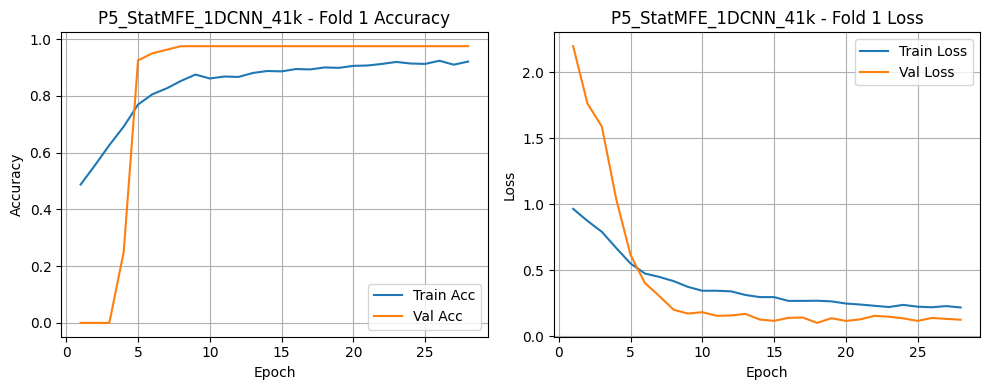

   P5_StatMFE_1DCNN_41k fold accuracy: 0.9100, F1-macro: 0.9188
   P5_StatMFE_1DCNN_41k inference time per sample (test): 0.001116 s
   P5_StatMFE_1DCNN_41k extra memory (train+test): 7.60 MB

🔍 CNN FOLD 2/5 (P5_StatMFE_1DCNN_41k, sr=41000)

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 38.


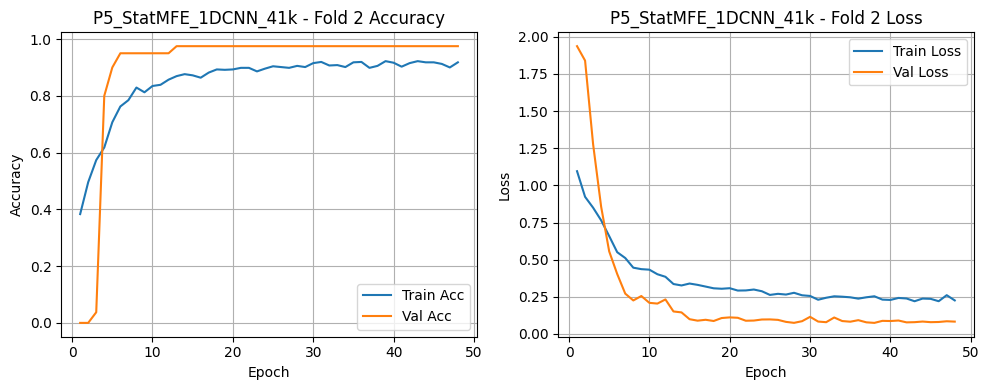

   P5_StatMFE_1DCNN_41k fold accuracy: 0.9450, F1-macro: 0.9520
   P5_StatMFE_1DCNN_41k inference time per sample (test): 0.001148 s
   P5_StatMFE_1DCNN_41k extra memory (train+test): 14.53 MB

🔍 CNN FOLD 3/5 (P5_StatMFE_1DCNN_41k, sr=41000)

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 35: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 25.


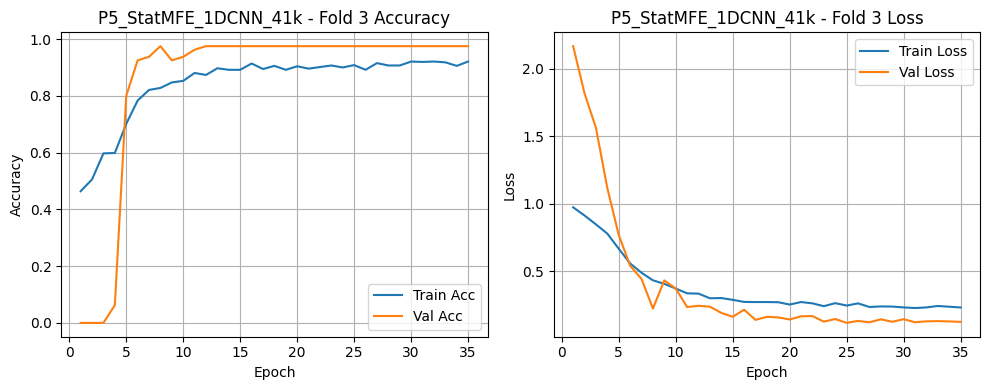

   P5_StatMFE_1DCNN_41k fold accuracy: 0.9050, F1-macro: 0.9167
   P5_StatMFE_1DCNN_41k inference time per sample (test): 0.000797 s
   P5_StatMFE_1DCNN_41k extra memory (train+test): 13.79 MB

🔍 CNN FOLD 4/5 (P5_StatMFE_1DCNN_41k, sr=41000)

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 40.


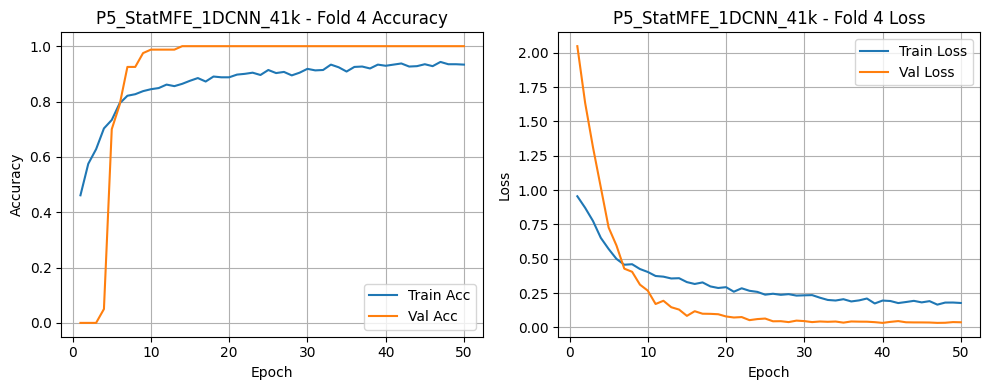

   P5_StatMFE_1DCNN_41k fold accuracy: 0.9350, F1-macro: 0.9458
   P5_StatMFE_1DCNN_41k inference time per sample (test): 0.000695 s
   P5_StatMFE_1DCNN_41k extra memory (train+test): 13.53 MB

🔍 CNN FOLD 5/5 (P5_StatMFE_1DCNN_41k, sr=41000)

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 41: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 31.


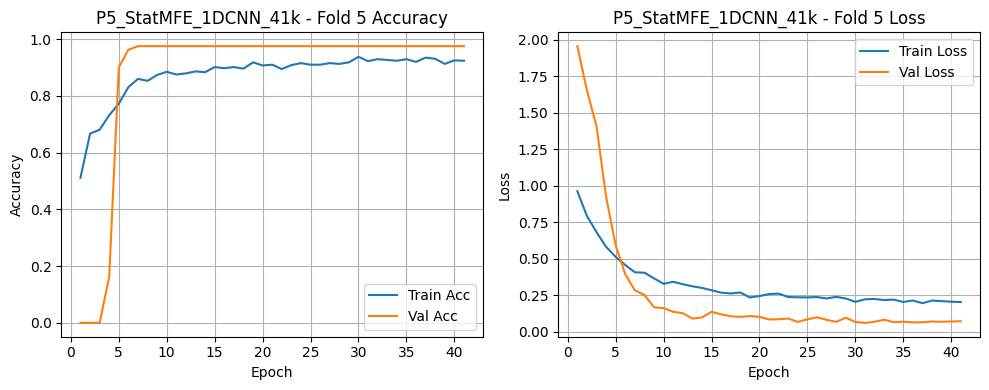

   P5_StatMFE_1DCNN_41k fold accuracy: 0.9350, F1-macro: 0.9458
   P5_StatMFE_1DCNN_41k inference time per sample (test): 0.000746 s
   P5_StatMFE_1DCNN_41k extra memory (train+test): 7.98 MB

HASIL 5-FOLD CROSS VALIDATION (P5_StatMFE_1DCNN_41k, sr=41000)
 No                Model Accuracy (mean±std) F1 Score (mean±std) Run Time Ekstraksi Fitur per Sampel [s] Run Time Inference per Sampel [s] (mean test) Memory usage tambahan [MB] (train+test, mean)
  1 P5_StatMFE_1DCNN_41k     0.9260 ± 0.0156     0.9358 ± 0.0150                                0.021215                                      0.000900                                         11.49
✅ Dataset loaded and Stat-MFE features extracted for CNN.
   Total samples (incl. augmentation): 1000
   Feature dimension: 396
   Total feature extraction time: 16.328 s
   Avg feature extraction time per sample: 0.016328 s
   Extra memory during feature extraction: 3.36 MB

🔍 CNN FOLD 1/5 (P6_StatMFE_1DCNN_16k, sr=16000)

Epoch 25: ReduceLROnPlat

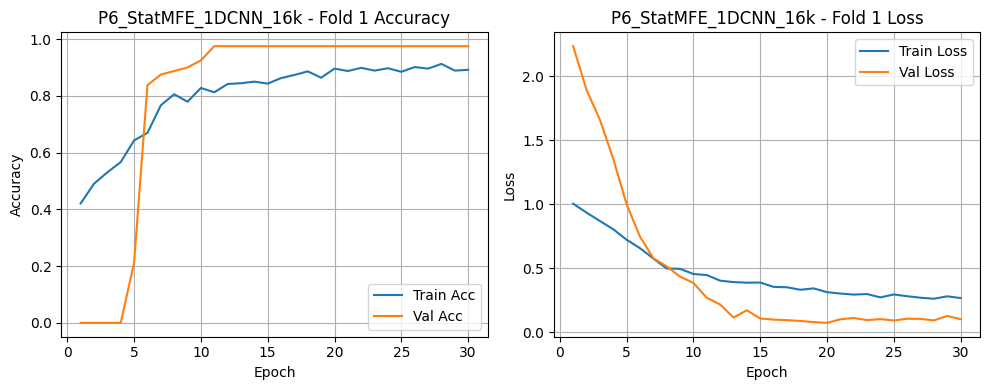

   P6_StatMFE_1DCNN_16k fold accuracy: 0.9000, F1-macro: 0.9128
   P6_StatMFE_1DCNN_16k inference time per sample (test): 0.000697 s
   P6_StatMFE_1DCNN_16k extra memory (train+test): 13.81 MB

🔍 CNN FOLD 2/5 (P6_StatMFE_1DCNN_16k, sr=16000)

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 29.


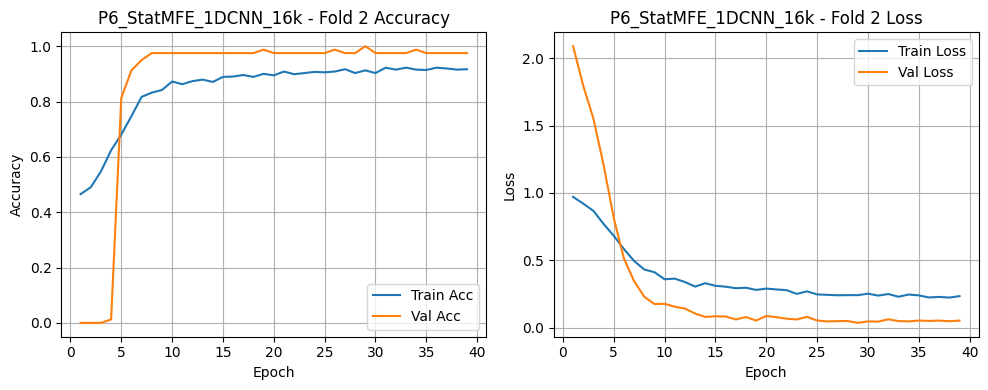

   P6_StatMFE_1DCNN_16k fold accuracy: 0.9150, F1-macro: 0.9269
   P6_StatMFE_1DCNN_16k inference time per sample (test): 0.000697 s
   P6_StatMFE_1DCNN_16k extra memory (train+test): 14.61 MB

🔍 CNN FOLD 3/5 (P6_StatMFE_1DCNN_16k, sr=16000)

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 29.


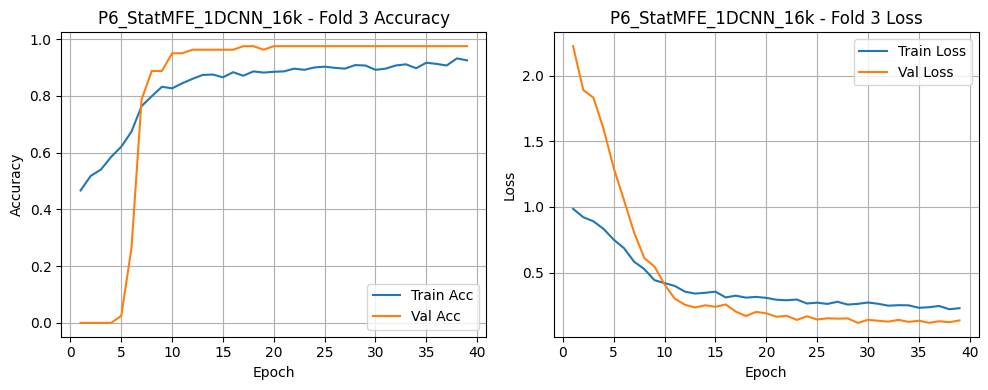

   P6_StatMFE_1DCNN_16k fold accuracy: 0.9300, F1-macro: 0.9397
   P6_StatMFE_1DCNN_16k inference time per sample (test): 0.000722 s
   P6_StatMFE_1DCNN_16k extra memory (train+test): 11.31 MB

🔍 CNN FOLD 4/5 (P6_StatMFE_1DCNN_16k, sr=16000)

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 37.


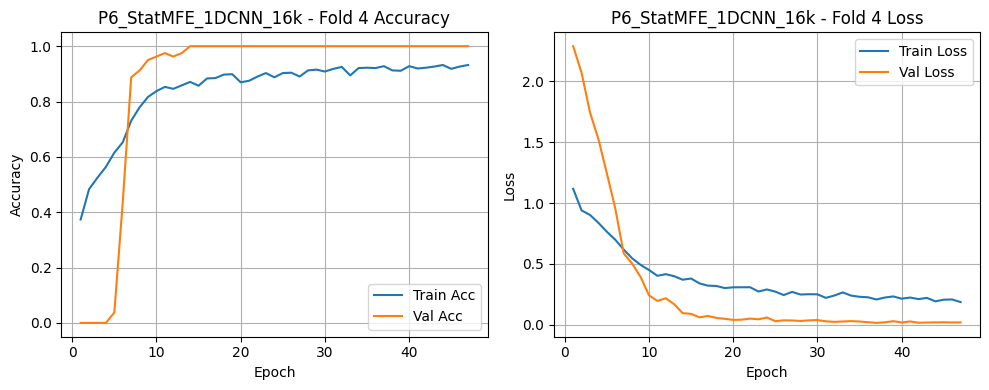

   P6_StatMFE_1DCNN_16k fold accuracy: 0.9200, F1-macro: 0.9294
   P6_StatMFE_1DCNN_16k inference time per sample (test): 0.000729 s
   P6_StatMFE_1DCNN_16k extra memory (train+test): 12.58 MB

🔍 CNN FOLD 5/5 (P6_StatMFE_1DCNN_16k, sr=16000)

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 34.


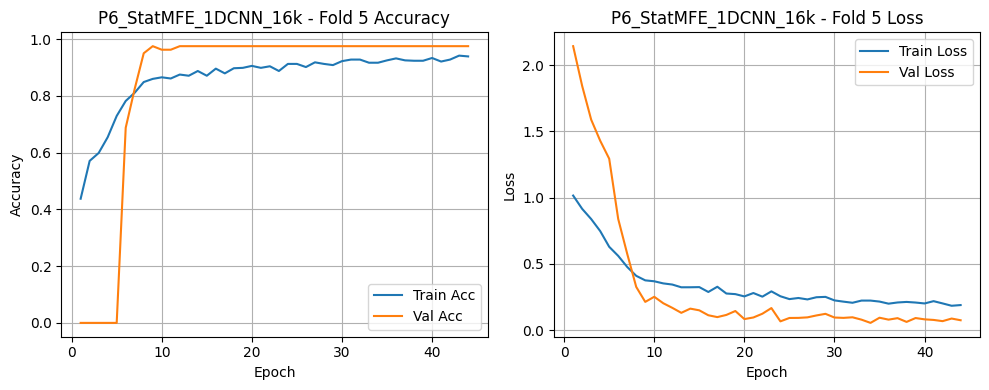

   P6_StatMFE_1DCNN_16k fold accuracy: 0.9400, F1-macro: 0.9500
   P6_StatMFE_1DCNN_16k inference time per sample (test): 0.000752 s
   P6_StatMFE_1DCNN_16k extra memory (train+test): 12.33 MB

HASIL 5-FOLD CROSS VALIDATION (P6_StatMFE_1DCNN_16k, sr=16000)
 No                Model Accuracy (mean±std) F1 Score (mean±std) Run Time Ekstraksi Fitur per Sampel [s] Run Time Inference per Sampel [s] (mean test) Memory usage tambahan [MB] (train+test, mean)
  1 P6_StatMFE_1DCNN_16k     0.9210 ± 0.0136     0.9318 ± 0.0125                                0.016328                                      0.000719                                         12.93


In [ ]:
import os
import time
import random
import psutil
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =========================
# Global configuration
# =========================

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: amanin GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# =========================
# Utility classes
# =========================

class Timer:
    """Simple timer utility to measure elapsed wall-clock time (in seconds)."""
    def __init__(self):
        self.start_time = None
        self.elapsed = 0.0

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        if self.start_time is not None:
            self.elapsed += time.perf_counter() - self.start_time
            self.start_time = None
        return self.elapsed

    def reset(self):
        self.start_time = None
        self.elapsed = 0.0

    def get_elapsed(self):
        return self.elapsed


class MemoryTracker:
    """
    Memory tracking utility (MB).
    Tracks baseline and peak RSS of the current process and
    returns delta (peak - baseline).
    """
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.baseline = self._get_current_memory()
        self.peak = self.baseline

    def _get_current_memory(self):
        return self.process.memory_info().rss / (1024 * 1024)

    def update(self):
        current = self._get_current_memory()
        if current > self.peak:
            self.peak = current
        return current

    def get_usage(self):
        # Update once more at the end and return peak - baseline
        self.update()
        return self.peak - self.baseline


class FeatureScaler:
    """
    Standardization (zero mean, unit variance)
    + Min-Max normalization to [0, 1].
    Fitted only on training data within each fold.
    """
    def __init__(self):
        self.mean_ = None
        self.std_ = None
        self.min_ = None
        self.max_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1.0  # avoid division by zero

        X_std = (X - self.mean_) / self.std_

        self.min_ = X_std.min(axis=0)
        self.max_ = X_std.max(axis=0)
        same = self.max_ == self.min_
        self.max_[same] = self.min_[same] + 1.0  # avoid zero range

    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_std = (X - self.mean_) / self.std_
        X_norm = (X_std - self.min_) / (self.max_ - self.min_)
        return X_norm

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


# =========================
# Feature extraction (Stat-MFE 396-D)
# =========================

class FeatureExtractor:
    """
    Feature extractor khusus Mel-Filterbank Energy (Stat-MFE 396-D).
    Seluruh preset dipetakan ke MFE-only demi konsistensi.
    """

    def __init__(self,
                 target_sr=16000,
                 duration=3.0,
                 frame_size=1024,
                 hop_length=512,
                 snr_db=15.0,
                 # argumen di bawah dipertahankan hanya agar API kompatibel
                 use_time=False,
                 use_basic_spectral=False,
                 use_minmaxfreq=False,
                 use_mfcc=False,
                 use_mfe=True,
                 use_chroma=False,
                 use_doppler=False):
        self.target_sr = target_sr
        self.duration = duration
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.snr_db = snr_db

        # FORCE: hanya MFE yang aktif
        self.use_time = False
        self.use_basic_spectral = False
        self.use_minmaxfreq = False
        self.use_mfcc = False
        self.use_mfe = True
        self.use_chroma = False
        self.use_doppler = False

    # ---------- Preset helper ----------

    @classmethod
    def from_preset(cls, preset_name, **kwargs):
        """
        Helper untuk bikin FeatureExtractor.
        Apa pun nilai preset_name, selalu Stat-MFE-only.
        kwargs dipakai untuk override (misal target_sr).
        """
        base = dict(
            target_sr=16000,
            duration=3.0,
            frame_size=1024,
            hop_length=512,
            snr_db=15.0,
            use_time=False,
            use_basic_spectral=False,
            use_minmaxfreq=False,
            use_mfcc=False,
            use_mfe=True,
            use_chroma=False,
            use_doppler=False,
        )
        base.update(kwargs)
        return cls(**base)

    # ---------- Preprocessing ----------

    def preprocess(self, y, sr):
        # Resample if needed
        if sr != self.target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.target_sr)

        # Fixed duration
        target_len = int(self.duration * self.target_sr)
        if len(y) > target_len:
            y = y[:target_len]
        elif len(y) < target_len:
            pad_width = target_len - len(y)
            y = np.pad(y, (0, pad_width), mode="constant")

        # Normalize amplitude to [-1, 1]
        max_amp = np.max(np.abs(y)) + 1e-12
        y = y / max_amp
        return y, self.target_sr

    # ---------- Augmentation ----------

    def augment(self, y):
        """
        White noise at target SNR with dynamic factor 0.5–1.5.
        Signal dan noise dinormalisasi sebelum dicampur.
        """
        signal_power = np.mean(y ** 2)
        noise_power = signal_power / (10.0 ** (self.snr_db / 10.0))

        white_noise = np.random.normal(0.0, np.sqrt(noise_power), size=len(y))
        dynamic_factor = np.random.uniform(0.5, 1.5, size=len(y))
        noise = white_noise * dynamic_factor

        sig_max = np.max(np.abs(y)) + 1e-12
        noise_max = np.max(np.abs(noise)) + 1e-12
        y_norm = y / sig_max
        noise_norm = noise / noise_max

        y_aug = y_norm + noise_norm
        y_aug = y_aug / (np.max(np.abs(y_aug)) + 1e-12)
        return y_aug

    # ---------- Spectrogram helper ----------

    def _compute_spectrogram(self, y):
        """
        Compute STFT + derived matrices once.
        Di sini hanya dipakai untuk MFE.
        """
        stft = librosa.stft(
            y,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            window="hann",
            center=False
        )
        P = np.abs(stft) ** 2  # power spectrogram (n_freqs, n_frames)
        freqs = librosa.fft_frequencies(sr=self.target_sr, n_fft=self.frame_size)
        S_db = librosa.power_to_db(P, ref=np.max)
        return stft, P, freqs, S_db

    # ---------- Stat-MFE 396-D ----------

    def extract_mfe_features(self, P):
        """
        Statistical Mel-Filterbank Energy (Stat-MFE):
        - 43 mel bands
        - 9 statistik per band:
          [mean, std, min, max, median, p10, p90, p25, p75]
        - 9 statistik global
        Total: 43×9 + 9 = 396 dimensi.
        """
        n_mels = 43

        mel_spec = librosa.feature.melspectrogram(
            S=P,
            sr=self.target_sr,
            n_mels=n_mels
        )  # (43, n_frames)

        mel_db = librosa.power_to_db(mel_spec, ref=np.max)  # (43, n_frames)

        def _nine_stats(x):
            x = np.asarray(x, dtype=np.float64)
            return np.array([
                np.mean(x),
                np.std(x),
                np.min(x),
                np.max(x),
                np.median(x),
                np.percentile(x, 10),
                np.percentile(x, 90),
                np.percentile(x, 25),
                np.percentile(x, 75),
            ], dtype=np.float64)

        # Statistik per mel band
        band_stats = []
        for b in range(n_mels):
            band_stats.append(_nine_stats(mel_db[b, :]))
        band_stats = np.stack(band_stats, axis=0)  # (43, 9)

        # 9 fitur global
        global_stats = _nine_stats(mel_db.reshape(-1))[None, :]  # (1, 9)

        # (44, 9) → flatten ke (396,)
        full_stats = np.vstack([band_stats, global_stats])  # (44, 9)
        stat_mfe = full_stats.reshape(-1)  # (396,)
        return stat_mfe

    # ---------- Public API: MFE-only ----------

    def extract_features_from_signal(self, y, sr, apply_augmentation=False):
        """
        MFE-only pipeline:
        - Preprocess (resample, durasi tetap, normalisasi)
        - (opsional) augment
        - STFT → power spectrogram (P)
        - Stat-MFE 396-D
        """
        y_proc, sr_proc = self.preprocess(y, sr)
        if apply_augmentation:
            y_proc = self.augment(y_proc)

        _, P, _, _ = self._compute_spectrogram(y_proc)
        mfe_feat = self.extract_mfe_features(P)
        return mfe_feat

    def extract_features_from_file(self, filepath, label=None, augment_for_labels=None):
        y, sr = librosa.load(filepath, sr=None, mono=True)

        feats = []
        # Original
        feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=False))

        # Augmented (only for some labels)
        if augment_for_labels is not None and label in augment_for_labels:
            feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=True))

        return feats


# =========================
# Dataset loader
# =========================

class AudioDataset:
    """
    Folder structure:
    base_dir/
        ambulance/*.wav
        firetruck/*.wav
        traffic/*.wav
    """
    def __init__(self, base_dir, feature_extractor,
                 class_names=None,
                 augment=True,
                 augment_for=("ambulance", "firetruck")):
        self.base_dir = base_dir
        self.fe = feature_extractor
        self.augment = augment
        if class_names is None:
            self.class_names = ["ambulance", "firetruck", "traffic"]
        else:
            self.class_names = class_names
        self.augment_for = set(augment_for)

    def load(self):
        X = []
        y = []

        for label in self.class_names:
            class_dir = os.path.join(self.base_dir, label)
            if not os.path.isdir(class_dir):
                continue
            for fname in sorted(os.listdir(class_dir)):
                if not fname.lower().endswith(".wav"):
                    continue
                fpath = os.path.join(class_dir, fname)
                features_list = self.fe.extract_features_from_file(
                    fpath,
                    label=label,
                    augment_for_labels=self.augment_for if self.augment else None
                )
                for feat in features_list:
                    X.append(feat)
                    y.append(label)

        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y)
        return X, y


# =========================
# P5/P6-style 1D-CNN untuk Stat-MFE 396-D
# =========================

def build_stat_mfe_cnn(input_shape, num_classes,
                       dropout_rate=0.30,
                       l2_lambda=1e-4,
                       lr=1e-3):
    """
    2-layer Conv1D (8→16) ala P5/P6:
    input: (44, 9)  # 44 "time steps" × 9 statistik
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(
        filters=8,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(
        filters=16,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(
        32,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


class CNNExperimentRunner:
    """
    Runner khusus Stat-MFE 396-D + 1D-CNN (P5/P6):
    - Fitur: Stat-MFE 396-D
    - Reshape ke (44, 9)
    - Model: 2-layer Conv1D (8→16) + Dense 32 + Softmax
    """
    def __init__(self, data_dir,
                 feature_preset="pmfe",
                 cnn_name="P5_StatMFE_1DCNN",
                 target_sr=16000):
        self.data_dir = data_dir
        self.fe = FeatureExtractor.from_preset(feature_preset, target_sr=target_sr)
        self.dataset = AudioDataset(data_dir, self.fe)
        self.label_encoder = LabelEncoder()
        self.cnn_name = cnn_name
        self.target_sr = target_sr

    # --- helper untuk load data + waktu ekstraksi ---
    def _prepare_dataset(self):
        feat_timer = Timer()
        feat_mem = MemoryTracker(interval=0.02)

        feat_mem.start()
        feat_timer.start()
        X_raw, y_labels = self.dataset.load()
        feat_timer.stop()
        feat_mem.stop()

        feat_mem_usage = feat_mem.delta_peak_mb  # ✅ peak delta MB


        n_samples_total = X_raw.shape[0]
        feat_time_total = feat_timer.get_elapsed()
        feat_time_per_sample = feat_time_total / n_samples_total

        print("✅ Dataset loaded and Stat-MFE features extracted for CNN.")
        print(f"   Total samples (incl. augmentation): {n_samples_total}")
        print(f"   Feature dimension: {X_raw.shape[1]}")
        print(f"   Total feature extraction time: {feat_time_total:.3f} s")
        print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
        print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} MB")

        return X_raw, y_labels, feat_time_per_sample

    # --- helper untuk plot history train vs val ---
    def _plot_history(self, history, fold_idx):
        """Plot accuracy & loss train vs val per epoch untuk 1 fold."""
        acc = history.history.get("accuracy", [])
        val_acc = history.history.get("val_accuracy", [])
        loss = history.history.get("loss", [])
        val_loss = history.history.get("val_loss", [])

        if not acc:
            print("⚠️ History kosong, tidak ada grafik yang bisa diplot.")
            return

        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(10, 4))

        # Plot Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label="Train Acc")
        plt.plot(epochs, val_acc, label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{self.cnn_name} - Fold {fold_idx} Accuracy")
        plt.legend()
        plt.grid(True)

        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label="Train Loss")
        plt.plot(epochs, val_loss, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{self.cnn_name} - Fold {fold_idx} Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def run(self, n_splits=5, epochs=100, batch_size=32, plot_each_fold=True):
        X_raw, y_labels, feat_time_per_sample = self._prepare_dataset()

        y = self.label_encoder.fit_transform(y_labels)
        num_classes = len(self.label_encoder.classes_)

        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED
        )

        acc_logs = []
        f1_logs = []
        infer_time_logs = []
        mem_logs = []

        fold_idx = 1
        last_history = None  # simpan history fold terakhir

        for train_idx, test_idx in skf.split(X_raw, y):
            print("\n" + "=" * 60)
            print(f"🔍 CNN FOLD {fold_idx}/{n_splits} ({self.cnn_name}, sr={self.target_sr})")
            print("=" * 60)

            X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Scaling
            scaler = FeatureScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)

            n_features = X_train_scaled.shape[1]
            channels = 9
            if n_features % channels != 0:
                raise ValueError(
                    f"Feature dimension {n_features} not divisible by {channels}; "
                    "tidak bisa reshape ke (time_steps, 9) untuk CNN."
                )
            time_steps = n_features // channels  # 396/9 = 44

            X_train_cnn = X_train_scaled.reshape(-1, time_steps, channels)
            X_test_cnn = X_test_scaled.reshape(-1, time_steps, channels)

            input_shape = (time_steps, channels)
            model = build_stat_mfe_cnn(input_shape, num_classes)

            callbacks = [
                EarlyStopping(
                    monitor="val_loss",
                    patience=10,
                    restore_best_weights=True,
                    verbose=1
                ),
                ReduceLROnPlateau(
                    monitor="val_loss",
                    factor=0.5,
                    patience=5,
                    min_lr=1e-5,
                    verbose=1
                ),
            ]

            mem_tracker = MemoryTracker()
            train_timer = Timer()
            infer_timer = Timer()

            # Train
            train_timer.start()
            history = model.fit(
                X_train_cnn,
                y_train,
                validation_split=0.1,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,
                callbacks=callbacks,
            )
            train_timer.stop()
            mem_tracker.update()

            last_history = history  # simpan history terakhir

            # OPTIONAL: plot setiap fold
            if plot_each_fold:
                self._plot_history(history, fold_idx)

            # Inference
            infer_timer.start()
            y_proba = model.predict(
                X_test_cnn,
                batch_size=batch_size,
                verbose=0
            )
            infer_timer.stop()
            mem_tracker.update()

            y_pred = np.argmax(y_proba, axis=1)

            mem_usage = mem_tracker.get_usage()
            infer_time_total = infer_timer.get_elapsed()
            infer_time_per_sample = infer_time_total / len(X_test_cnn)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="macro")

            acc_logs.append(acc)
            f1_logs.append(f1)
            infer_time_logs.append(infer_time_per_sample)
            mem_logs.append(mem_usage)

            print(f"   {self.cnn_name} fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
            print(f"   {self.cnn_name} inference time per sample (test): {infer_time_per_sample:.6f} s")
            print(f"   {self.cnn_name} peak RAM (RSS) train+test): {mem_usage:.2f} MB")

            fold_idx += 1
            tf.keras.backend.clear_session()

        # Kalau tidak plot per fold, plot sekali untuk fold terakhir
        if not plot_each_fold and last_history is not None:
            self._plot_history(last_history, fold_idx - 1)

        # Summary
        acc_mean = np.mean(acc_logs)
        acc_std = np.std(acc_logs)
        f1_mean = np.mean(f1_logs)
        f1_std = np.std(f1_logs)
        infer_mean = np.mean(infer_time_logs)
        mem_mean = np.mean(mem_logs)

        results_df = pd.DataFrame([{
            "Model": self.cnn_name,
            "Accuracy (mean±std)": f"{acc_mean:.4f} ± {acc_std:.4f}",
            "F1 Score (mean±std)": f"{f1_mean:.4f} ± {f1_std:.4f}",
            "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
            "Run Time Inference per Sampel [s] (mean test)": f"{infer_mean:.6f}",
            "Memory usage tambahan [MB] (train+test, mean)": f"{mem_mean:.2f}"
        }])
        results_df.insert(0, "No", [1])

        print("\n" + "=" * 80)
        print(f"HASIL 5-FOLD CROSS VALIDATION ({self.cnn_name}, sr={self.target_sr})")
        print("=" * 80)
        print(results_df.to_string(index=False))

        return results_df


# =========================
# Main
# =========================

if __name__ == "__main__":
    data_dir = "./sounds"

    # --- P5: Stat-MFE 1D-CNN @ 41 kHz (misal meniru pipeline Jayakumar) ---
    runner_p5 = CNNExperimentRunner(
        data_dir=data_dir,
        feature_preset="pmfe",
        cnn_name="P5_StatMFE_1DCNN_41k",
        target_sr=41000  # atau 44100 kalau dataset aslinya 44.1 kHz
    )
    results_p5 = runner_p5.run(n_splits=5, epochs=100, batch_size=32, plot_each_fold=True)

    # --- P6: Stat-MFE 1D-CNN @ 16 kHz (pipeline optimisasi) ---
    runner_p6 = CNNExperimentRunner(
        data_dir=data_dir,
        feature_preset="pmfe",
        cnn_name="P6_StatMFE_1DCNN_16k",
        target_sr=16000
    )
    results_p6 = runner_p6.run(n_splits=5, epochs=100, batch_size=32, plot_each_fold=True)


✅ Dataset loaded and Stat-MFE features extracted for CNN.
   Total samples (incl. augmentation): 1000
   Feature dimension: 396
   Total feature extraction time: 16.185 s
   Avg feature extraction time per sample: 0.016185 s
   Extra memory during feature extraction: 4.84 MB

🔍 CNN FOLD 1/5 (P6_StatMFE_1DCNN_16k, sr=16000)

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 25.


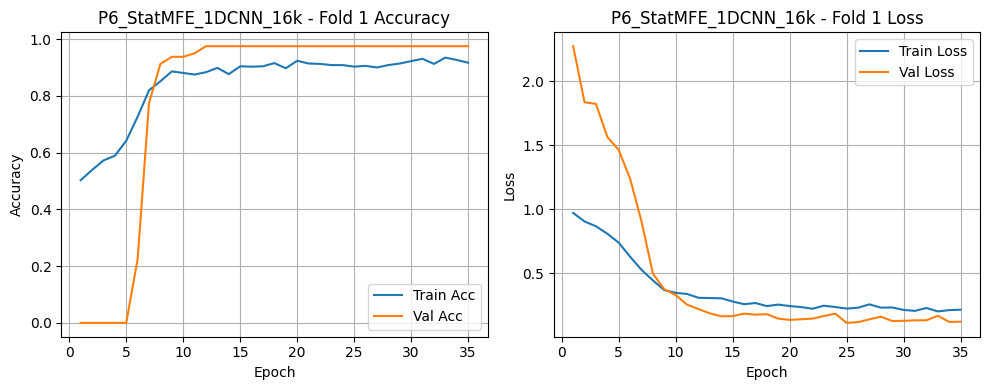

   P6_StatMFE_1DCNN_16k fold accuracy: 0.9100, F1-macro: 0.9231
   P6_StatMFE_1DCNN_16k inference time per sample (test): 0.001515 s
   P6_StatMFE_1DCNN_16k extra memory (train+test): 12.25 MB

🔍 CNN FOLD 2/5 (P6_StatMFE_1DCNN_16k, sr=16000)

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 34.


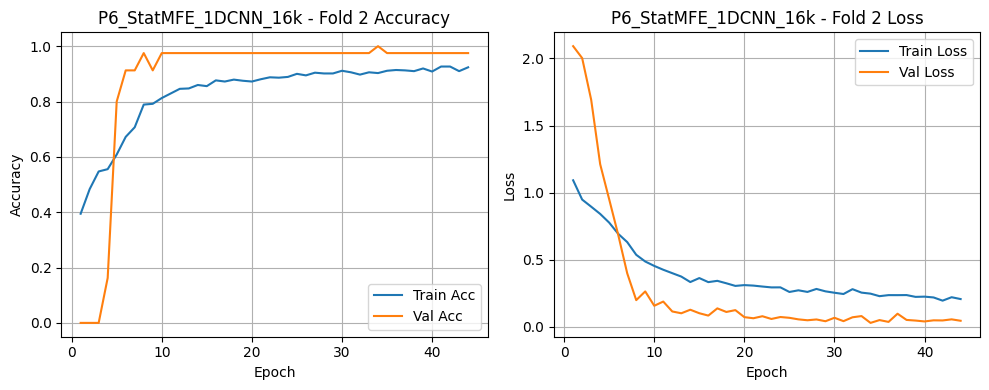

   P6_StatMFE_1DCNN_16k fold accuracy: 0.9300, F1-macro: 0.9394
   P6_StatMFE_1DCNN_16k inference time per sample (test): 0.000824 s
   P6_StatMFE_1DCNN_16k extra memory (train+test): 12.66 MB

🔍 CNN FOLD 3/5 (P6_StatMFE_1DCNN_16k, sr=16000)

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 42: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 32.


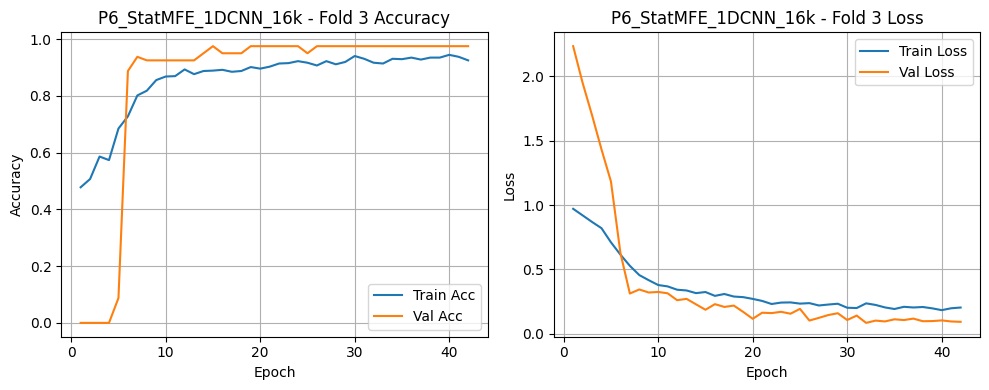

   P6_StatMFE_1DCNN_16k fold accuracy: 0.9400, F1-macro: 0.9458
   P6_StatMFE_1DCNN_16k inference time per sample (test): 0.000700 s
   P6_StatMFE_1DCNN_16k extra memory (train+test): 12.12 MB

🔍 CNN FOLD 4/5 (P6_StatMFE_1DCNN_16k, sr=16000)

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 36.


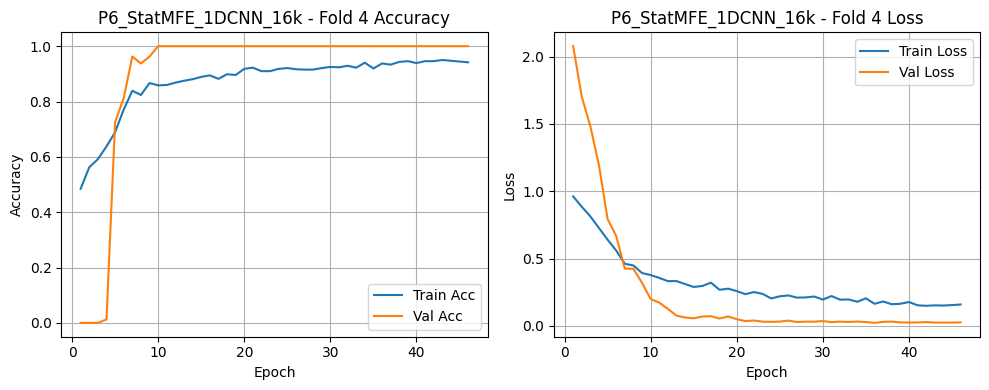

   P6_StatMFE_1DCNN_16k fold accuracy: 0.9350, F1-macro: 0.9458
   P6_StatMFE_1DCNN_16k inference time per sample (test): 0.001079 s
   P6_StatMFE_1DCNN_16k extra memory (train+test): 13.23 MB

🔍 CNN FOLD 5/5 (P6_StatMFE_1DCNN_16k, sr=16000)

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 24.


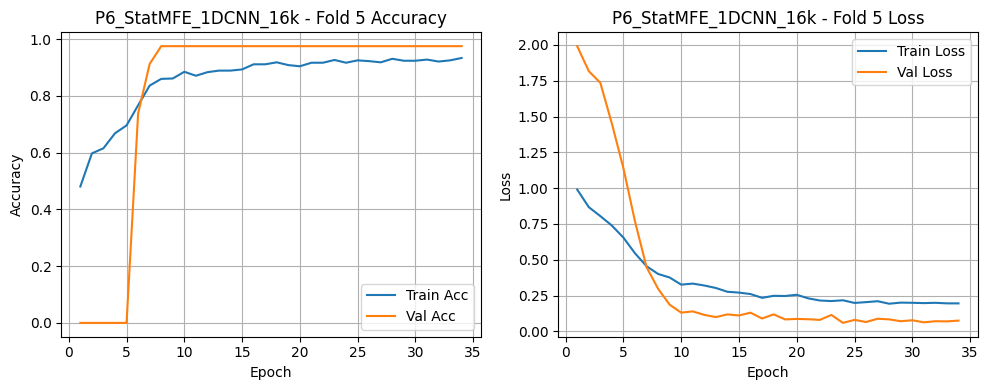

   P6_StatMFE_1DCNN_16k fold accuracy: 0.9450, F1-macro: 0.9542
   P6_StatMFE_1DCNN_16k inference time per sample (test): 0.000705 s
   P6_StatMFE_1DCNN_16k extra memory (train+test): 12.46 MB

HASIL 5-FOLD CROSS VALIDATION (P6_StatMFE_1DCNN_16k, sr=16000)
 No                Model Accuracy (mean±std) F1 Score (mean±std) Run Time Ekstraksi Fitur per Sampel [s] Run Time Inference per Sampel [s] (mean test) Memory usage tambahan [MB] (train+test, mean)
  1 P6_StatMFE_1DCNN_16k     0.9320 ± 0.0121     0.9417 ± 0.0104                                0.016185                                      0.000965                                         12.54


In [ ]:
import os
import time
import random
import psutil
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =========================
# Global configuration
# =========================

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: amanin GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# =========================
# Utility classes
# =========================

class Timer:
    """Simple timer utility to measure elapsed wall-clock time (in seconds)."""
    def __init__(self):
        self.start_time = None
        self.elapsed = 0.0

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        if self.start_time is not None:
            self.elapsed += time.perf_counter() - self.start_time
            self.start_time = None
        return self.elapsed

    def reset(self):
        self.start_time = None
        self.elapsed = 0.0

    def get_elapsed(self):
        return self.elapsed


class MemoryTracker:
    """
    Memory tracking utility (MB).
    Tracks baseline and peak RSS of the current process and
    returns delta (peak - baseline).
    """
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.baseline = self._get_current_memory()
        self.peak = self.baseline

    def _get_current_memory(self):
        return self.process.memory_info().rss / (1024 * 1024)

    def update(self):
        current = self._get_current_memory()
        if current > self.peak:
            self.peak = current
        return current

    def get_usage(self):
        # Update once more at the end and return peak - baseline
        self.update()
        return self.peak - self.baseline


class FeatureScaler:
    """
    Standardization (zero mean, unit variance)
    + Min-Max normalization to [0, 1].
    Fitted only on training data within each fold.
    """
    def __init__(self):
        self.mean_ = None
        self.std_ = None
        self.min_ = None
        self.max_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1.0  # avoid division by zero

        X_std = (X - self.mean_) / self.std_

        self.min_ = X_std.min(axis=0)
        self.max_ = X_std.max(axis=0)
        same = self.max_ == self.min_
        self.max_[same] = self.min_[same] + 1.0  # avoid zero range

    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_std = (X - self.mean_) / self.std_
        X_norm = (X_std - self.min_) / (self.max_ - self.min_)
        return X_norm

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


# =========================
# Feature extraction (Stat-MFE 396-D)
# =========================

class FeatureExtractor:
    """
    Feature extractor khusus Mel-Filterbank Energy (Stat-MFE 396-D).
    Seluruh preset dipetakan ke MFE-only demi konsistensi.
    """

    def __init__(self,
                 target_sr=16000,
                 duration=3.0,
                 frame_size=1024,
                 hop_length=512,
                 snr_db=15.0,
                 # argumen di bawah dipertahankan hanya agar API kompatibel
                 use_time=False,
                 use_basic_spectral=False,
                 use_minmaxfreq=False,
                 use_mfcc=False,
                 use_mfe=True,
                 use_chroma=False,
                 use_doppler=False):
        self.target_sr = target_sr
        self.duration = duration
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.snr_db = snr_db

        # FORCE: hanya MFE yang aktif
        self.use_time = False
        self.use_basic_spectral = False
        self.use_minmaxfreq = False
        self.use_mfcc = False
        self.use_mfe = True
        self.use_chroma = False
        self.use_doppler = False

    # ---------- Preset helper ----------

    @classmethod
    def from_preset(cls, preset_name, **kwargs):
        """
        Helper untuk bikin FeatureExtractor.
        Apa pun nilai preset_name, selalu Stat-MFE-only.
        kwargs dipakai untuk override (misal target_sr).
        """
        base = dict(
            target_sr=16000,
            duration=3.0,
            frame_size=1024,
            hop_length=512,
            snr_db=15.0,
            use_time=False,
            use_basic_spectral=False,
            use_minmaxfreq=False,
            use_mfcc=False,
            use_mfe=True,
            use_chroma=False,
            use_doppler=False,
        )
        base.update(kwargs)
        return cls(**base)

    # ---------- Preprocessing ----------

    def preprocess(self, y, sr):
        # Resample if needed
        if sr != self.target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.target_sr)

        # Fixed duration
        target_len = int(self.duration * self.target_sr)
        if len(y) > target_len:
            y = y[:target_len]
        elif len(y) < target_len:
            pad_width = target_len - len(y)
            y = np.pad(y, (0, pad_width), mode="constant")

        # Normalize amplitude to [-1, 1]
        max_amp = np.max(np.abs(y)) + 1e-12
        y = y / max_amp
        return y, self.target_sr

    # ---------- Augmentation ----------

    def augment(self, y):
        """
        White noise at target SNR with dynamic factor 0.5–1.5.
        Signal dan noise dinormalisasi sebelum dicampur.
        """
        signal_power = np.mean(y ** 2)
        noise_power = signal_power / (10.0 ** (self.snr_db / 10.0))

        white_noise = np.random.normal(0.0, np.sqrt(noise_power), size=len(y))
        dynamic_factor = np.random.uniform(0.5, 1.5, size=len(y))
        noise = white_noise * dynamic_factor

        sig_max = np.max(np.abs(y)) + 1e-12
        noise_max = np.max(np.abs(noise)) + 1e-12
        y_norm = y / sig_max
        noise_norm = noise / noise_max

        y_aug = y_norm + noise_norm
        y_aug = y_aug / (np.max(np.abs(y_aug)) + 1e-12)
        return y_aug

    # ---------- Spectrogram helper ----------

    def _compute_spectrogram(self, y):
        """
        Compute STFT + derived matrices once.
        Di sini hanya dipakai untuk MFE.
        """
        stft = librosa.stft(
            y,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            window="hann",
            center=False
        )
        P = np.abs(stft) ** 2  # power spectrogram (n_freqs, n_frames)
        freqs = librosa.fft_frequencies(sr=self.target_sr, n_fft=self.frame_size)
        S_db = librosa.power_to_db(P, ref=np.max)
        return stft, P, freqs, S_db

    # ---------- Stat-MFE 396-D ----------

    def extract_mfe_features(self, P):
        """
        Statistical Mel-Filterbank Energy (Stat-MFE):
        - 43 mel bands
        - 9 statistik per band:
          [mean, std, min, max, median, p10, p90, p25, p75]
        - 9 statistik global
        Total: 43×9 + 9 = 396 dimensi.
        """
        n_mels = 43

        mel_spec = librosa.feature.melspectrogram(
            S=P,
            sr=self.target_sr,
            n_mels=n_mels
        )  # (43, n_frames)

        mel_db = librosa.power_to_db(mel_spec, ref=np.max)  # (43, n_frames)

        def _nine_stats(x):
            x = np.asarray(x, dtype=np.float64)
            return np.array([
                np.mean(x),
                np.std(x),
                np.min(x),
                np.max(x),
                np.median(x),
                np.percentile(x, 10),
                np.percentile(x, 90),
                np.percentile(x, 25),
                np.percentile(x, 75),
            ], dtype=np.float64)

        # Statistik per mel band
        band_stats = []
        for b in range(n_mels):
            band_stats.append(_nine_stats(mel_db[b, :]))
        band_stats = np.stack(band_stats, axis=0)  # (43, 9)

        # 9 fitur global
        global_stats = _nine_stats(mel_db.reshape(-1))[None, :]  # (1, 9)

        # (44, 9) → flatten ke (396,)
        full_stats = np.vstack([band_stats, global_stats])  # (44, 9)
        stat_mfe = full_stats.reshape(-1)  # (396,)
        return stat_mfe

    # ---------- Public API: MFE-only ----------

    def extract_features_from_signal(self, y, sr, apply_augmentation=False):
        """
        MFE-only pipeline:
        - Preprocess (resample, durasi tetap, normalisasi)
        - (opsional) augment
        - STFT → power spectrogram (P)
        - Stat-MFE 396-D
        """
        y_proc, sr_proc = self.preprocess(y, sr)
        if apply_augmentation:
            y_proc = self.augment(y_proc)

        _, P, _, _ = self._compute_spectrogram(y_proc)
        mfe_feat = self.extract_mfe_features(P)
        return mfe_feat

    def extract_features_from_file(self, filepath, label=None, augment_for_labels=None):
        y, sr = librosa.load(filepath, sr=None, mono=True)

        feats = []
        # Original
        feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=False))

        # Augmented (only for some labels)
        if augment_for_labels is not None and label in augment_for_labels:
            feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=True))

        return feats


# =========================
# Dataset loader
# =========================

class AudioDataset:
    """
    Folder structure:
    base_dir/
        ambulance/*.wav
        firetruck/*.wav
        traffic/*.wav
    """
    def __init__(self, base_dir, feature_extractor,
                 class_names=None,
                 augment=True,
                 augment_for=("ambulance", "firetruck")):
        self.base_dir = base_dir
        self.fe = feature_extractor
        self.augment = augment
        if class_names is None:
            self.class_names = ["ambulance", "firetruck", "traffic"]
        else:
            self.class_names = class_names
        self.augment_for = set(augment_for)

    def load(self):
        X = []
        y = []

        for label in self.class_names:
            class_dir = os.path.join(self.base_dir, label)
            if not os.path.isdir(class_dir):
                continue
            for fname in sorted(os.listdir(class_dir)):
                if not fname.lower().endswith(".wav"):
                    continue
                fpath = os.path.join(class_dir, fname)
                features_list = self.fe.extract_features_from_file(
                    fpath,
                    label=label,
                    augment_for_labels=self.augment_for if self.augment else None
                )
                for feat in features_list:
                    X.append(feat)
                    y.append(label)

        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y)
        return X, y


# =========================
# P5/P6-style 1D-CNN untuk Stat-MFE 396-D
# =========================

def build_stat_mfe_cnn(input_shape, num_classes,
                       dropout_rate=0.30,
                       l2_lambda=1e-4,
                       lr=1e-3):
    """
    2-layer Conv1D (8→16) ala P5/P6:
    input: (44, 9)  # 44 "time steps" × 9 statistik
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(
        filters=8,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(
        filters=16,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(
        32,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


class CNNExperimentRunner:
    """
    Runner khusus Stat-MFE 396-D + 1D-CNN (P5/P6):
    - Fitur: Stat-MFE 396-D
    - Reshape ke (44, 9)
    - Model: 2-layer Conv1D (8→16) + Dense 32 + Softmax
    """
    def __init__(self, data_dir,
                 feature_preset="pmfe",
                 cnn_name="P5_StatMFE_1DCNN",
                 target_sr=16000):
        self.data_dir = data_dir
        self.fe = FeatureExtractor.from_preset(feature_preset, target_sr=target_sr)
        self.dataset = AudioDataset(data_dir, self.fe)
        self.label_encoder = LabelEncoder()
        self.cnn_name = cnn_name
        self.target_sr = target_sr

    # --- helper untuk load data + waktu ekstraksi ---
    def _prepare_dataset(self):
        feat_timer = Timer()
        feat_mem = MemoryTracker(interval=0.02)

        feat_mem.start()
        feat_timer.start()
        X_raw, y_labels = self.dataset.load()
        feat_timer.stop()
        feat_mem.stop()

        feat_mem_usage = feat_mem.delta_peak_mb  # ✅ peak delta MB


        n_samples_total = X_raw.shape[0]
        feat_time_total = feat_timer.get_elapsed()
        feat_time_per_sample = feat_time_total / n_samples_total

        print("✅ Dataset loaded and Stat-MFE features extracted for CNN.")
        print(f"   Total samples (incl. augmentation): {n_samples_total}")
        print(f"   Feature dimension: {X_raw.shape[1]}")
        print(f"   Total feature extraction time: {feat_time_total:.3f} s")
        print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
        print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} MB")

        return X_raw, y_labels, feat_time_per_sample

    # --- helper untuk plot history train vs val ---
    def _plot_history(self, history, fold_idx):
        """Plot accuracy & loss train vs val per epoch untuk 1 fold."""
        acc = history.history.get("accuracy", [])
        val_acc = history.history.get("val_accuracy", [])
        loss = history.history.get("loss", [])
        val_loss = history.history.get("val_loss", [])

        if not acc:
            print("⚠️ History kosong, tidak ada grafik yang bisa diplot.")
            return

        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(10, 4))

        # Plot Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label="Train Acc")
        plt.plot(epochs, val_acc, label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{self.cnn_name} - Fold {fold_idx} Accuracy")
        plt.legend()
        plt.grid(True)

        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label="Train Loss")
        plt.plot(epochs, val_loss, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{self.cnn_name} - Fold {fold_idx} Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def run(self, n_splits=5, epochs=100, batch_size=32, plot_each_fold=True):
        X_raw, y_labels, feat_time_per_sample = self._prepare_dataset()

        y = self.label_encoder.fit_transform(y_labels)
        num_classes = len(self.label_encoder.classes_)

        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED
        )

        acc_logs = []
        f1_logs = []
        infer_time_logs = []
        mem_logs = []

        fold_idx = 1
        last_history = None  # simpan history fold terakhir

        for train_idx, test_idx in skf.split(X_raw, y):
            print("\n" + "=" * 60)
            print(f"🔍 CNN FOLD {fold_idx}/{n_splits} ({self.cnn_name}, sr={self.target_sr})")
            print("=" * 60)

            X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Scaling
            scaler = FeatureScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)

            n_features = X_train_scaled.shape[1]
            channels = 9
            if n_features % channels != 0:
                raise ValueError(
                    f"Feature dimension {n_features} not divisible by {channels}; "
                    "tidak bisa reshape ke (time_steps, 9) untuk CNN."
                )
            time_steps = n_features // channels  # 396/9 = 44

            X_train_cnn = X_train_scaled.reshape(-1, time_steps, channels)
            X_test_cnn = X_test_scaled.reshape(-1, time_steps, channels)

            input_shape = (time_steps, channels)
            model = build_stat_mfe_cnn(input_shape, num_classes)

            callbacks = [
                EarlyStopping(
                    monitor="val_loss",
                    patience=10,
                    restore_best_weights=True,
                    verbose=1
                ),
                ReduceLROnPlateau(
                    monitor="val_loss",
                    factor=0.5,
                    patience=5,
                    min_lr=1e-5,
                    verbose=1
                ),
            ]

            mem_tracker = MemoryTracker()
            train_timer = Timer()
            infer_timer = Timer()

            # Train
            train_timer.start()
            history = model.fit(
                X_train_cnn,
                y_train,
                validation_split=0.1,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,
                callbacks=callbacks,
            )
            train_timer.stop()
            mem_tracker.update()

            last_history = history  # simpan history terakhir

            # OPTIONAL: plot setiap fold
            if plot_each_fold:
                self._plot_history(history, fold_idx)

            # Inference
            infer_timer.start()
            y_proba = model.predict(
                X_test_cnn,
                batch_size=batch_size,
                verbose=0
            )
            infer_timer.stop()
            mem_tracker.update()

            y_pred = np.argmax(y_proba, axis=1)

            mem_usage = mem_tracker.get_usage()
            infer_time_total = infer_timer.get_elapsed()
            infer_time_per_sample = infer_time_total / len(X_test_cnn)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="macro")

            acc_logs.append(acc)
            f1_logs.append(f1)
            infer_time_logs.append(infer_time_per_sample)
            mem_logs.append(mem_usage)

            print(f"   {self.cnn_name} fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
            print(f"   {self.cnn_name} inference time per sample (test): {infer_time_per_sample:.6f} s")
            print(f"   {self.cnn_name} peak RAM (RSS) train+test): {mem_usage:.2f} MB")

            fold_idx += 1
            tf.keras.backend.clear_session()

        # Kalau tidak plot per fold, plot sekali untuk fold terakhir
        if not plot_each_fold and last_history is not None:
            self._plot_history(last_history, fold_idx - 1)

        # Summary
        acc_mean = np.mean(acc_logs)
        acc_std = np.std(acc_logs)
        f1_mean = np.mean(f1_logs)
        f1_std = np.std(f1_logs)
        infer_mean = np.mean(infer_time_logs)
        mem_mean = np.mean(mem_logs)

        results_df = pd.DataFrame([{
            "Model": self.cnn_name,
            "Accuracy (mean±std)": f"{acc_mean:.4f} ± {acc_std:.4f}",
            "F1 Score (mean±std)": f"{f1_mean:.4f} ± {f1_std:.4f}",
            "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
            "Run Time Inference per Sampel [s] (mean test)": f"{infer_mean:.6f}",
            "Memory usage tambahan [MB] (train+test, mean)": f"{mem_mean:.2f}"
        }])
        results_df.insert(0, "No", [1])

        print("\n" + "=" * 80)
        print(f"HASIL 5-FOLD CROSS VALIDATION ({self.cnn_name}, sr={self.target_sr})")
        print("=" * 80)
        print(results_df.to_string(index=False))

        return results_df


# =========================
# Main
# =========================

if __name__ == "__main__":
    data_dir = "./sounds"
    # --- P6: Stat-MFE 1D-CNN @ 16 kHz (pipeline optimisasi) ---
    runner_p6 = CNNExperimentRunner(
        data_dir=data_dir,
        feature_preset="pmfe",
        cnn_name="P6_StatMFE_1DCNN_16k",
        target_sr=16000
    )
    results_p6 = runner_p6.run(n_splits=5, epochs=100, batch_size=32, plot_each_fold=True)
